In [55]:
from ultralytics import SAM

# Load a model
model = SAM("sam_b.pt")

# Display model information (optional)
model.info()


Model summary: 173 layers, 93,735,472 parameters, 93,735,472 gradients


(173, 93735472, 93735472, 0.0)

In [56]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import ffmpeg
import shutil
import json
from scipy.ndimage import convolve


def extract_frames(video_path, output_folder, interval):
    os.makedirs(output_folder, exist_ok=True)
    ffmpeg.input(video_path, ss=0).output(
        f"{output_folder}frame_%03d.png", vf=f"fps=1/{interval}"
    ).run()


def medial_axis_transform(binary_image):
    binary = (binary_image > 0).astype(np.uint8) * 255
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    skeleton = np.zeros(binary.shape, dtype=np.uint8)
    temp = binary.copy()

    while cv2.countNonZero(temp) > 0:
        eroded = cv2.erode(temp, kernel)
        opened = cv2.dilate(eroded, kernel)
        subtract = cv2.subtract(temp, opened)
        skeleton = cv2.bitwise_or(skeleton, subtract)
        temp = eroded.copy()
    return skeleton


def create_SAM_mask(image_path, point):
    frame = cv2.imread(image_path)
    results = model(image_path, points=point, labels=[1])
    b_mask = np.zeros(frame.shape[:2], np.uint8)

    contour = results[0].masks.xy.pop()
    contour = contour.astype(np.int32)
    contour = contour.reshape(-1, 1, 2)
    _ = cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)

    return b_mask


def eucledian_distance_map(skeleton, point):
    skeleton_binary = (skeleton > 0).astype(np.uint8)
    y, x = np.indices(skeleton_binary.shape)
    distance_map = np.sqrt((x - point[0]) ** 2 + (y - point[1]) ** 2)
    display_map = np.zeros_like(distance_map, dtype=np.float32)
    display_map[skeleton_binary > 0] = distance_map[skeleton_binary > 0]
    return display_map


def track_actuator_tip(
    frame_folder,
    start_frame,
    anchor_point,
    output_file,
    json_output_file,
    end_frame=None,
    maximum_tip_travel_between_frames=100,
    edge_cushion=0,
    wandering_point_top=None,
    wandering_point_bottpm=60,
    tip_margin=1,
    debug=False,
    no_wandering_anchor=False,
    opening_kernel=(3, 3),
    calculate_distance_relative_to_original_anchor=False,
):
    frames = sorted(
        [
            os.path.join(frame_folder, f)
            for f in os.listdir(frame_folder)
            if f.endswith((".png", ".jpg"))
        ]
    )

    start_frame = max(0, start_frame)
    end_frame = min(len(frames), end_frame if end_frame is not None else len(frames))
    print(f"Analyzing frames {start_frame} to {end_frame-1}")
    print(f"Total frames used: {end_frame - start_frame}")

    frames = frames[start_frame:end_frame]

    tip_positions = []
    frame_times = []
    prev_corner = None
    tracking_data = {"frames": []}

    plt.figure(figsize=(12, 10))
    wandering_point = anchor_point
    for i, frame_path in enumerate(frames):
        frame = cv2.imread(frame_path)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        b_mask = create_SAM_mask(frame_path, wandering_point)
        total_image_y_len, total_image_x_len = b_mask.shape
        white_pixels = np.column_stack(np.where(b_mask == 255))
        # Keep the wandering point at the top of the finger of bacterial leather
        if wandering_point_top is None:
            wandering_point_top = wandering_point_bottpm - 20
        filtered_pixels = [
            pixel
            for pixel in white_pixels
            if (
                pixel[1] >= edge_cushion
                and pixel[1] <= total_image_x_len - edge_cushion
                and pixel[0] >= wandering_point_top
                and pixel[0] <= wandering_point_bottpm
            )
        ]
        print(len(filtered_pixels), edge_cushion, total_image_x_len - edge_cushion, )
        cy, cx = np.mean(filtered_pixels, axis=0).astype(int)

        kernel = np.ones(opening_kernel, np.uint8)
        cleaned_b_mask = cv2.morphologyEx(b_mask, cv2.MORPH_OPEN, kernel, iterations=5)
        skeleton = medial_axis_transform(cleaned_b_mask)
        if calculate_distance_relative_to_original_anchor:
            distance_map = eucledian_distance_map(skeleton, anchor_point)
        else:
            distance_map = eucledian_distance_map(skeleton, wandering_point)

        result = frame_rgb.copy()
        tip_point = None
        if debug or i % 5 == 0:
            fig, axes = plt.subplots(2, 3, figsize=(15, 10))

            axes[0, 0].imshow(frame_rgb)
            axes[0, 0].set_title("Frame")
            axes[0, 0].axis("off")
            axes[0, 1].imshow(frame_rgb)
            axes[0, 1].set_title("Frame with Point Selected")
            size = 10  # Size of the "X"
            thickness = 2  # Thickness of the lines
            axes[0, 1].plot(
                [wandering_point[0] - size, wandering_point[0] + size],
                [wandering_point[1] - size, wandering_point[1] + size],
                color="green",
                linewidth=thickness,
            )
            axes[0, 1].plot(
                [wandering_point[0] - size, wandering_point[0] + size],
                [wandering_point[1] + size, wandering_point[1] - size],
                color="green",
                linewidth=thickness,
            )
            axes[0, 1].axis("off")
            axes[0, 2].imshow(b_mask, cmap="gray")
            axes[0, 2].set_title("Binary Mask")
            axes[0, 2].axis("off")
            axes[1, 0].imshow(cleaned_b_mask, cmap="gray")
            axes[1, 0].set_title("Cleaned Binary Mask")
            axes[1, 0].axis("off")
            axes[1, 1].imshow(skeleton, cmap="gray")
            axes[1, 1].set_title("Skeleton")
            axes[1, 1].axis("off")
            axes[1, 2].imshow(distance_map)
            axes[1, 2].set_title("Distance Mapped Skeleton")
            axes[1, 2].axis("off")
            plt.tight_layout()
            plt.show()

        if no_wandering_anchor:
            wandering_point = anchor_point
        else:
            wandering_point = (cx, cy)

        if i == 0:
            max_distance = np.max(distance_map)
            max_points = np.column_stack(np.where(distance_map == max_distance))
            # Filter points within a small margin of the maximum distance
            near_max_points = max_points[
                distance_map[max_points[:, 0], max_points[:, 1]]
                >= (max_distance - tip_margin)
            ]

            # Select the bottom-right point among these near-max points
            prev_corner = near_max_points[
                np.lexsort((near_max_points[:, 1], near_max_points[:, 0]))[-1]
            ][
                ::-1
            ]  # Convert to (x, y)

            tip_point = tuple(prev_corner)

        else:
            x, y = prev_corner

            y_min = max(edge_cushion, y - maximum_tip_travel_between_frames // 2)
            y_max = min(
                distance_map.shape[0] - edge_cushion,
                y + maximum_tip_travel_between_frames // 2,
            )
            x_min = max(edge_cushion, x - maximum_tip_travel_between_frames // 2)
            x_max = min(
                distance_map.shape[1] - edge_cushion,
                x + maximum_tip_travel_between_frames // 2,
            )

            window = distance_map[y_min:y_max, x_min:x_max]

            if np.any(~np.isnan(window)):
                max_window_distance = np.max(window)
                max_window_points = np.column_stack(
                    np.where(window == max_window_distance)
                )

                near_max_window_points = max_window_points[
                    window[max_window_points[:, 0], max_window_points[:, 1]]
                    >= (max_window_distance - tip_margin)
                ]

                local_max_idx = near_max_window_points[
                    np.lexsort(
                        (near_max_window_points[:, 1], near_max_window_points[:, 0])
                    )[-1]
                ]

                tip_point = (x_min + local_max_idx[1], y_min + local_max_idx[0])
                prev_corner = tip_point
            else:
                raise Exception("No valid points found in search window")

        if tip_point is not None:
            cv2.circle(result, tip_point, 5, (0, 0, 255), -1)
            tip_positions.append(tip_point)
            frame_times.append(i)

            import base64
            from io import BytesIO

            _, buffer = cv2.imencode(".png", b_mask)
            mask_base64 = base64.b64encode(buffer).decode("utf-8")

            frame_data = {
                "frame_index": start_frame + i,
                "frame_path": frame_path,
                "tip_position": {"x": int(tip_point[0]), "y": int(tip_point[1])},
                "anchor_point": {
                    "x": int(wandering_point[0]),
                    "y": int(wandering_point[1]),
                },
                "mask": mask_base64,
            }

            tracking_data["frames"].append(frame_data)

            with open(json_output_file, "w") as f:
                json.dump(tracking_data, f)
        if debug or i % 5 == 0:
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(result)
            plt.title(f"Frame {i} - Detected Tip")
            plt.axis("off")

            if len(tip_positions) > 1:
                tip_array = np.array(tip_positions)
                plt.subplot(1, 2, 2)
                plt.plot(tip_array[:, 0], tip_array[:, 1], "b-o")
                plt.scatter(tip_array[-1, 0], tip_array[-1, 1], color="red", s=100)
                plt.gca().invert_yaxis()
                plt.title("Tip Trajectory")
                plt.xlabel("X Position (pixels)")
                plt.ylabel("Y Position (pixels)")
                plt.grid(True)

            plt.tight_layout()
            plt.draw()
            plt.pause(0.1)
            plt.close()

    if tip_positions:
        tip_array = np.array(tip_positions)
        np.savetxt(
            output_file,
            np.column_stack((frame_times, tip_array)),
            delimiter=",",
            header="minutes,x,y",
            comments="",
        )

        plt.figure(figsize=(10, 8))
        plt.plot(tip_array[:, 0], tip_array[:, 1], "b-o")
        plt.gca().invert_yaxis()
        plt.title("Complete Tip Trajectory")
        plt.xlabel("X Position (pixels)")
        plt.ylabel("Y Position (pixels)")
        plt.grid(True)
        plt.savefig("tip_trajectory.png")
        plt.show()

    return tip_positions, frame_times  # , tracking_data

In [57]:
# # Set paths
# video_name = f"control_idx0_100x" # without the .mov
# video_path = f"bimorph_videos/{video_name}.mov"
# temp_folder = "tracking_frames/"
# start_frame = 3
# end_frame = None
# frame_interval=0.6
# point = (290, 50)

# extract_frames(video_path, temp_folder, interval=frame_interval)

# track_actuator_tip(
#     frame_folder=temp_folder,
#     start_frame=start_frame,
#     end_frame=end_frame,
#     output_file=f"tracked_trajectories/{video_name}_tracked.csv",
#     json_output_file=f"tracked_trajectories/{video_name}_json.csv",
#     anchor_point=point,
#     maximum_tip_travel_between_frames = 100,
#     edge_cushion =0,
# )


# for filename in os.listdir(temp_folder):
#     file_path = os.path.join(temp_folder, filename)
#     if os.path.isdir(file_path):
#         shutil.rmtree(file_path)
#     else:
#         os.remove(file_path)

In [58]:
# # Set paths
# video_name = f"control_idx1_100x" # without the .mov
# video_path = f"bimorph_videos/{video_name}.mov"
# temp_folder = "tracking_frames/"
# start_frame = 3
# end_frame = None
# frame_interval=0.6
# point = (315, 50)

# extract_frames(video_path, temp_folder, interval=frame_interval)

# track_actuator_tip(
#     frame_folder=temp_folder,
#     start_frame=start_frame,
#     end_frame=end_frame,
#     output_file=f"tracked_trajectories/{video_name}_tracked.csv",
#     json_output_file=f"tracked_trajectories/{video_name}_json.csv",
#     anchor_point=point,
#     edge_cushion =0
# )


# for filename in os.listdir(temp_folder):
#     file_path = os.path.join(temp_folder, filename)
#     if os.path.isdir(file_path):
#         shutil.rmtree(file_path)
#     else:
#         os.remove(file_path)

In [59]:
# # Set paths
# video_name = f"control_idx2_100x" # without the .mov
# video_path = f"bimorph_videos/{video_name}.mov"
# temp_folder = "tracking_frames/"
# start_frame = 3
# end_frame = 44
# frame_interval=0.6
# point = (345, 50)

# extract_frames(video_path, temp_folder, interval=frame_interval)

# track_actuator_tip(
#     frame_folder=temp_folder,
#     start_frame=start_frame,
#     end_frame=end_frame,
#     output_file=f"tracked_trajectories/{video_name}_tracked.csv",
#     json_output_file=f"tracked_trajectories/{video_name}_json.csv",
#     anchor_point=point,
#     edge_cushion =0
# )


# for filename in os.listdir(temp_folder):
#     file_path = os.path.join(temp_folder, filename)
#     if os.path.isdir(file_path):
#         shutil.rmtree(file_path)
#     else:
#         os.remove(file_path)

In [60]:
# # Set paths
# video_name = f"control_idx3_100x" # without the .mov
# video_path = f"bimorph_videos/{video_name}.mov"
# temp_folder = "tracking_frames/"
# start_frame = 3
# end_frame = None
# frame_interval=0.6
# point = (315, 50)

# extract_frames(video_path, temp_folder, interval=frame_interval)

# track_actuator_tip(
#     frame_folder=temp_folder,
#     start_frame=start_frame,
#     end_frame=end_frame,
#     output_file=f"tracked_trajectories/{video_name}_tracked.csv",
#     json_output_file=f"tracked_trajectories/{video_name}_json.csv",
#     anchor_point=point,
#     maximum_tip_travel_between_frames = 300,
#     edge_cushion =0,
#     tip_margin=40,
#     debug=True
# )


# for filename in os.listdir(temp_folder):
#     file_path = os.path.join(temp_folder, filename)
#     if os.path.isdir(file_path):
#         shutil.rmtree(file_path)
#     else:
#         os.remove(file_path)

ffmpeg version 6.1.1-3ubuntu5 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13 (Ubuntu 13.2.0-23ubuntu3)
  configuration: --prefix=/usr --extra-version=3ubuntu5 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --disable-omx --enable-gnutls --enable-libaom --enable-libass --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libharfbuzz --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-libzimg --ena

Analyzing frames 0 to 35
Total frames used: 36

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_001.png: 1024x1024 1 0, 357.6ms
Speed: 3.1ms preprocess, 357.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
11799 0 640


<Figure size 1200x1000 with 0 Axes>

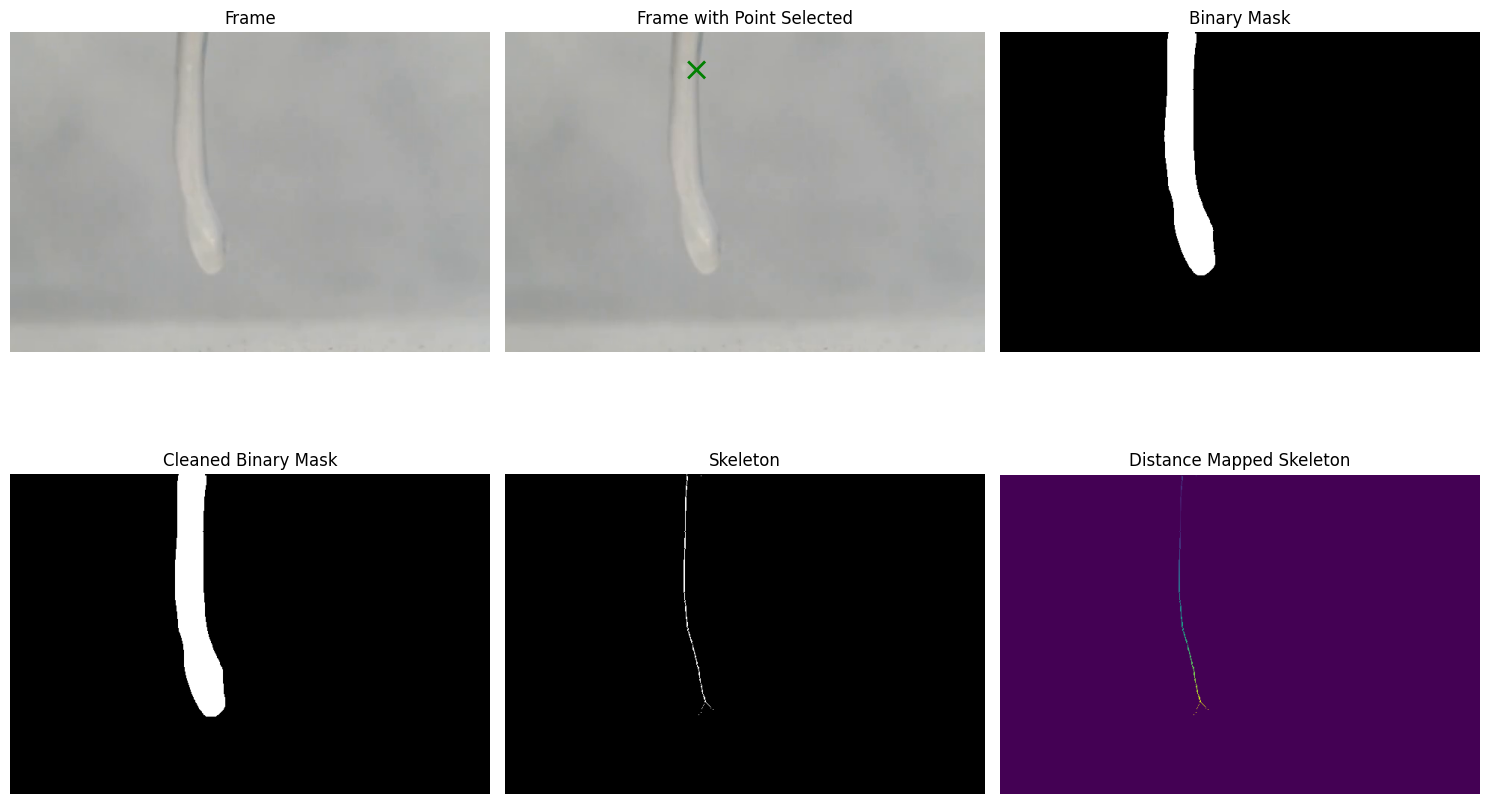

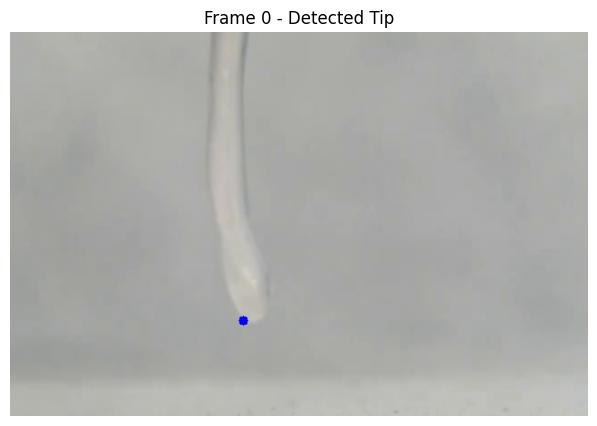


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_002.png: 1024x1024 1 0, 336.7ms
Speed: 4.8ms preprocess, 336.7ms inference, 0.5ms postprocess per image at shape (1, 3, 1024, 1024)
11165 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_003.png: 1024x1024 1 0, 327.9ms
Speed: 3.1ms preprocess, 327.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
11047 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_004.png: 1024x1024 1 0, 330.5ms
Speed: 3.9ms preprocess, 330.5ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)
10747 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_005.png: 1024x1024 1 0, 334.9ms
Speed: 3.1ms preprocess, 334.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
10851 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_006.png: 1024x

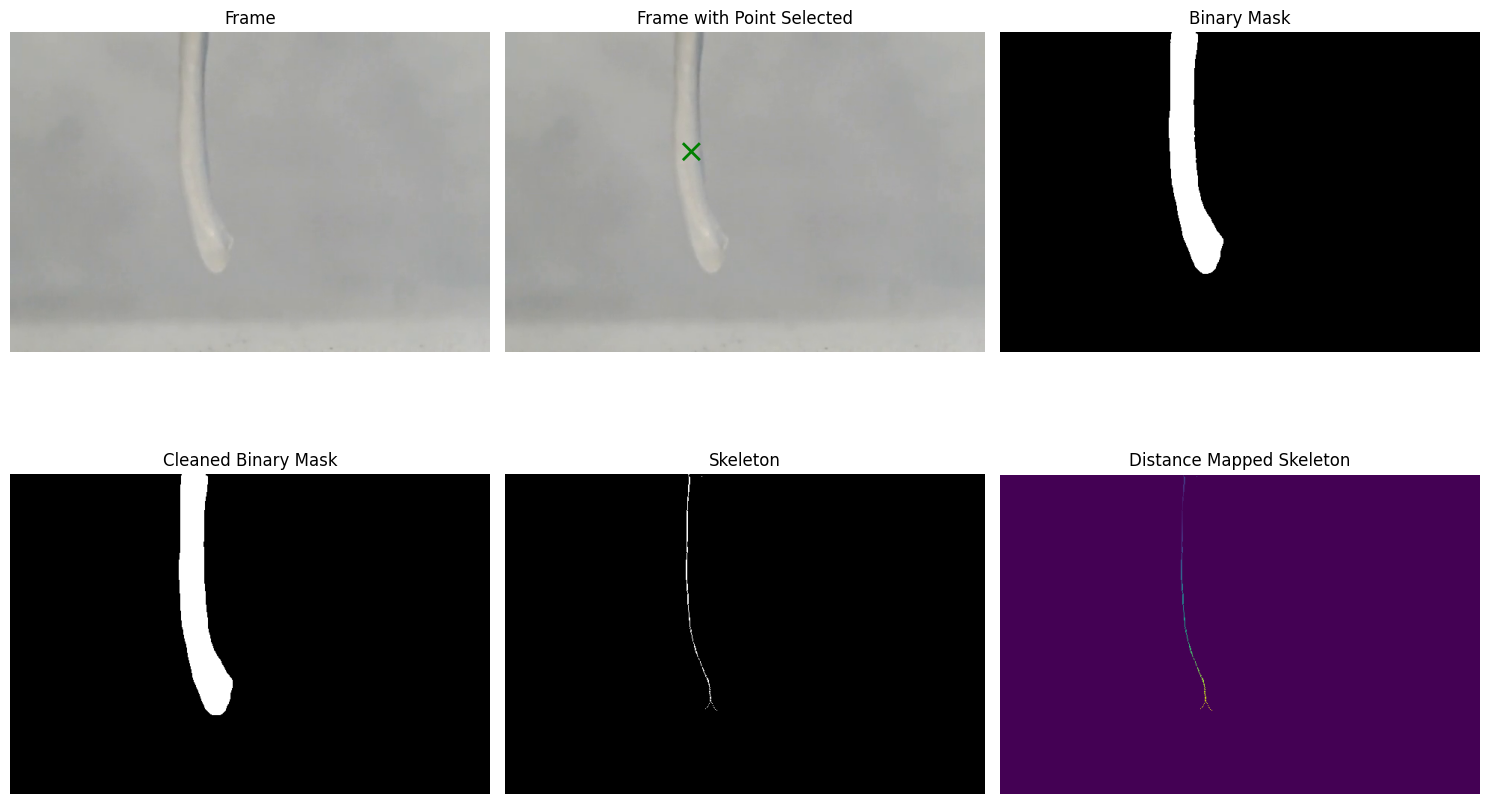

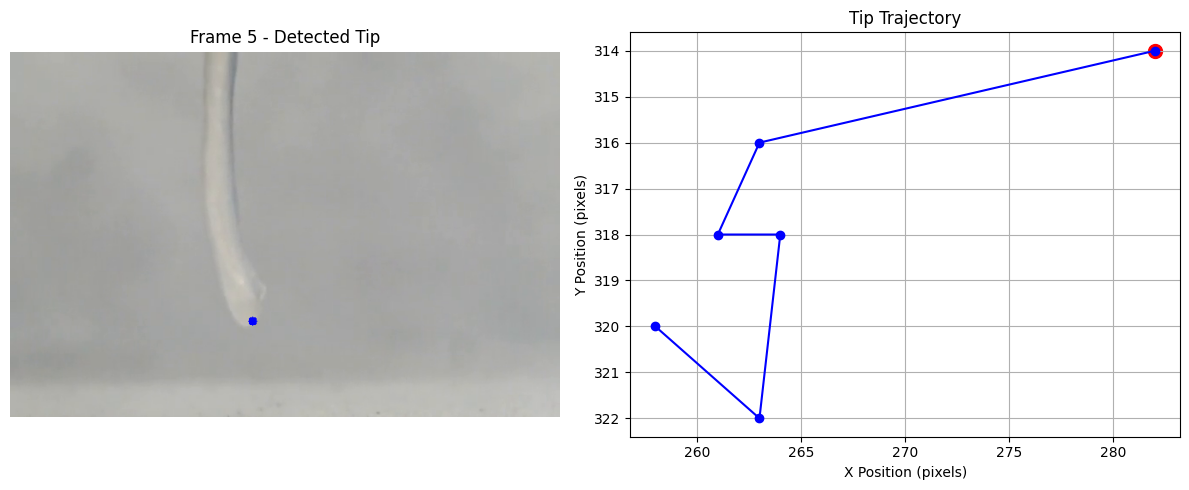


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_007.png: 1024x1024 1 0, 344.5ms
Speed: 4.8ms preprocess, 344.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
11042 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_008.png: 1024x1024 1 0, 331.5ms
Speed: 3.0ms preprocess, 331.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
10962 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_009.png: 1024x1024 1 0, 331.6ms
Speed: 3.0ms preprocess, 331.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
10732 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_010.png: 1024x1024 1 0, 331.6ms
Speed: 3.4ms preprocess, 331.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
10405 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_011.png: 1024x

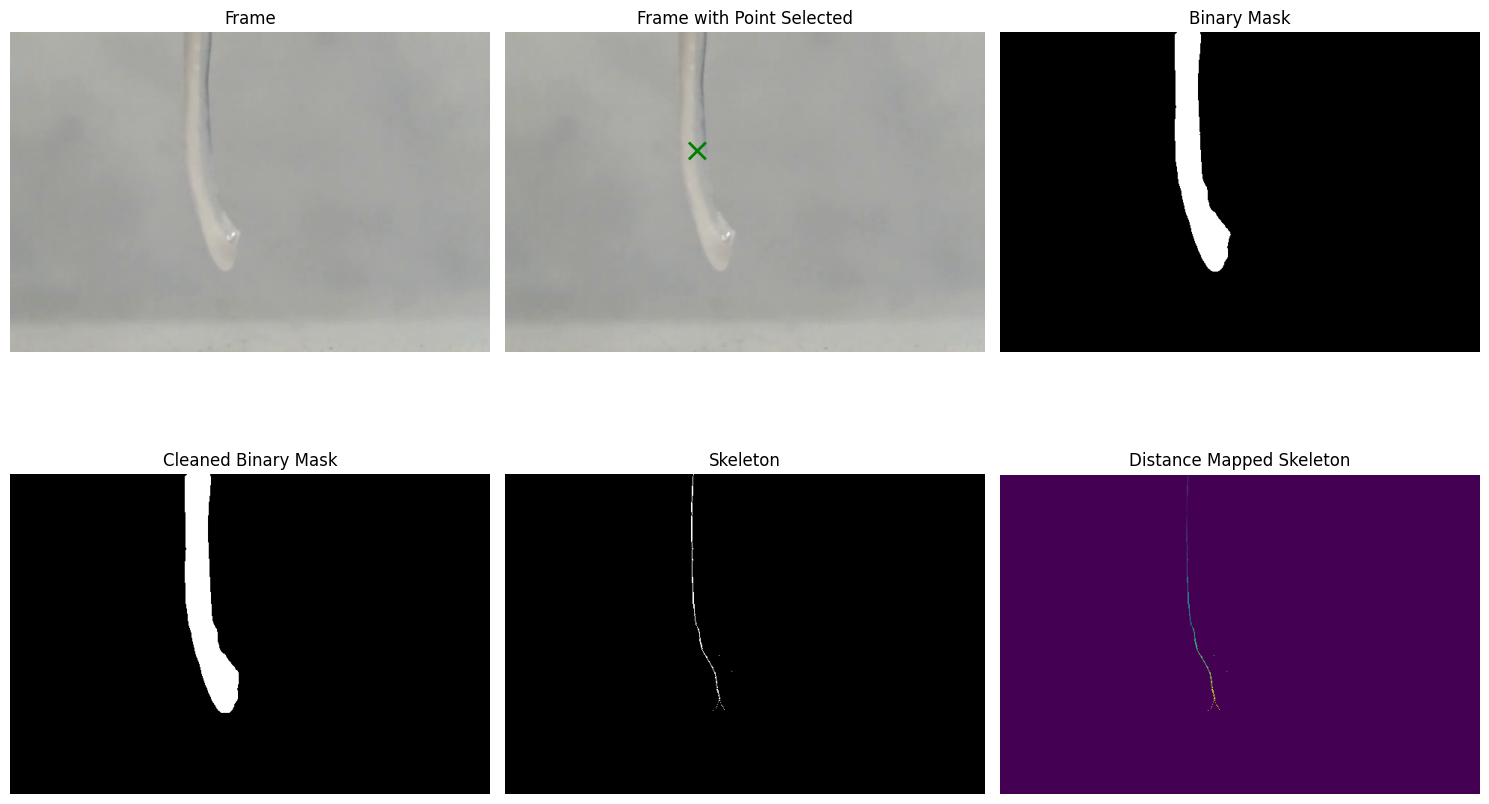

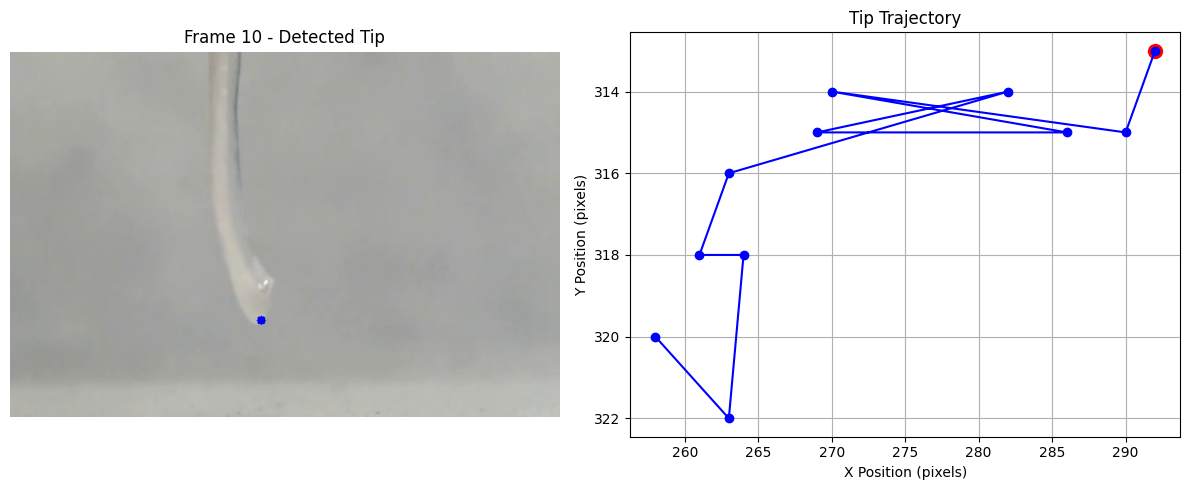


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_012.png: 1024x1024 1 0, 334.5ms
Speed: 4.8ms preprocess, 334.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
10343 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_013.png: 1024x1024 1 0, 334.8ms
Speed: 3.0ms preprocess, 334.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
10180 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_014.png: 1024x1024 1 0, 332.0ms
Speed: 3.0ms preprocess, 332.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
10350 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_015.png: 1024x1024 1 0, 331.4ms
Speed: 3.0ms preprocess, 331.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
9932 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_016.png: 1024x1

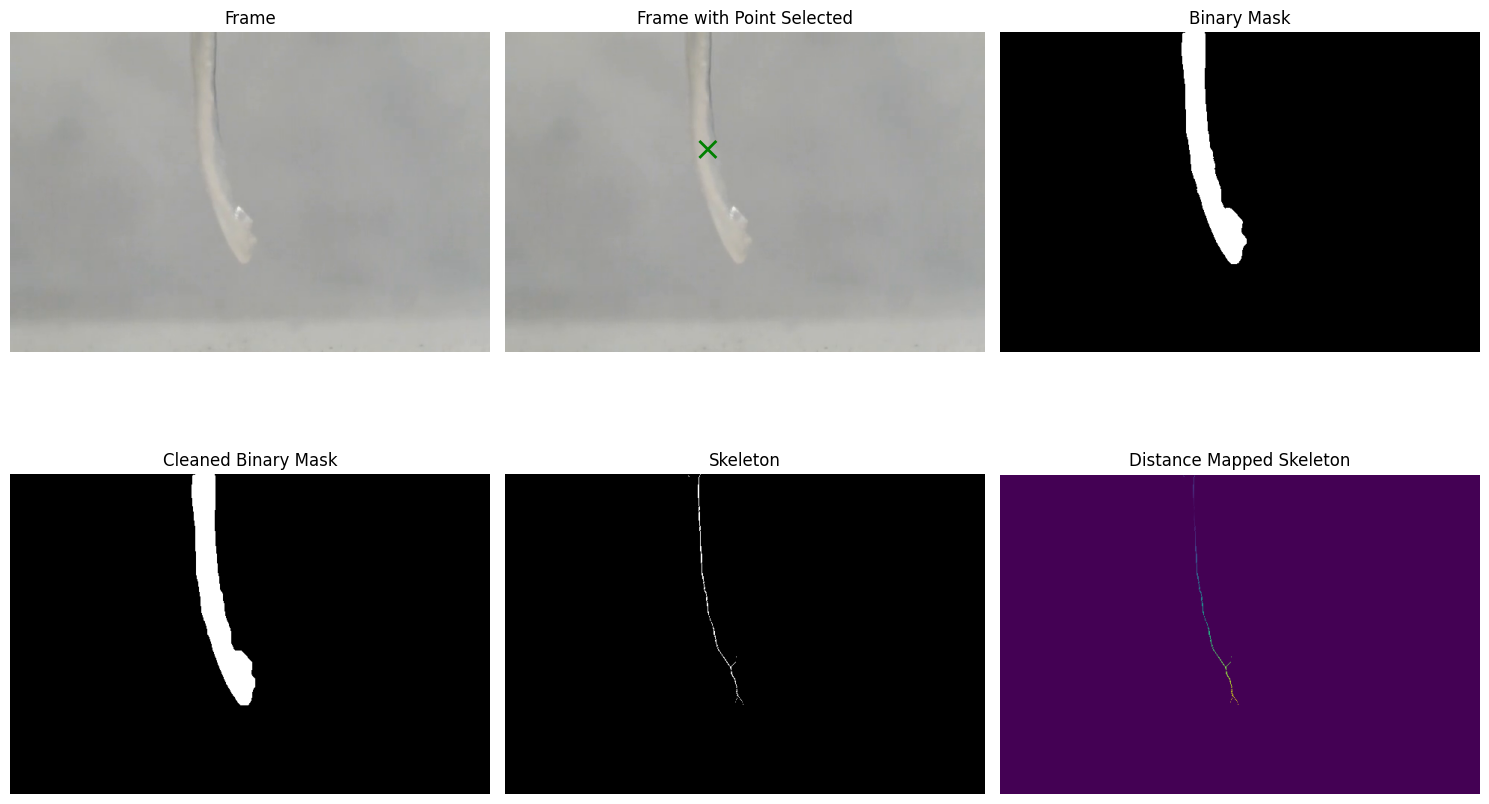

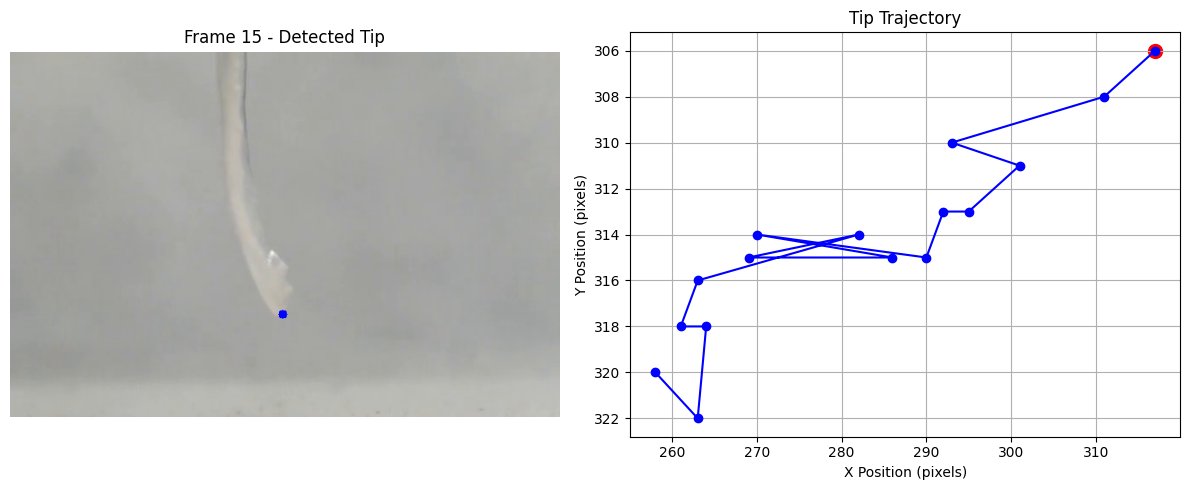


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_017.png: 1024x1024 1 0, 334.4ms
Speed: 4.9ms preprocess, 334.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
9652 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_018.png: 1024x1024 1 0, 331.8ms
Speed: 3.0ms preprocess, 331.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
9651 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_019.png: 1024x1024 1 0, 332.1ms
Speed: 3.0ms preprocess, 332.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
9670 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_020.png: 1024x1024 1 0, 331.9ms
Speed: 4.1ms preprocess, 331.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
11148 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_021.png: 1024x102

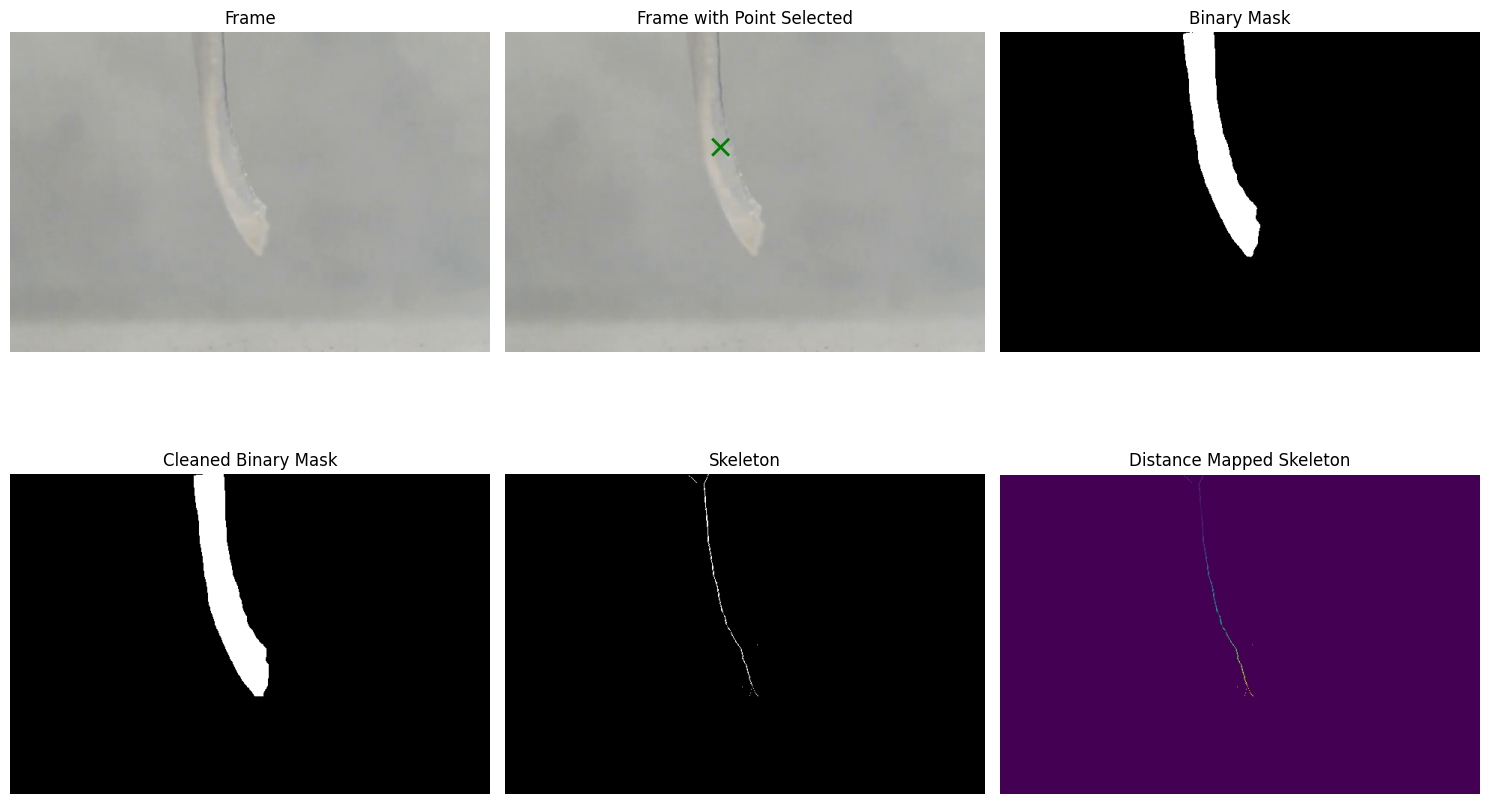

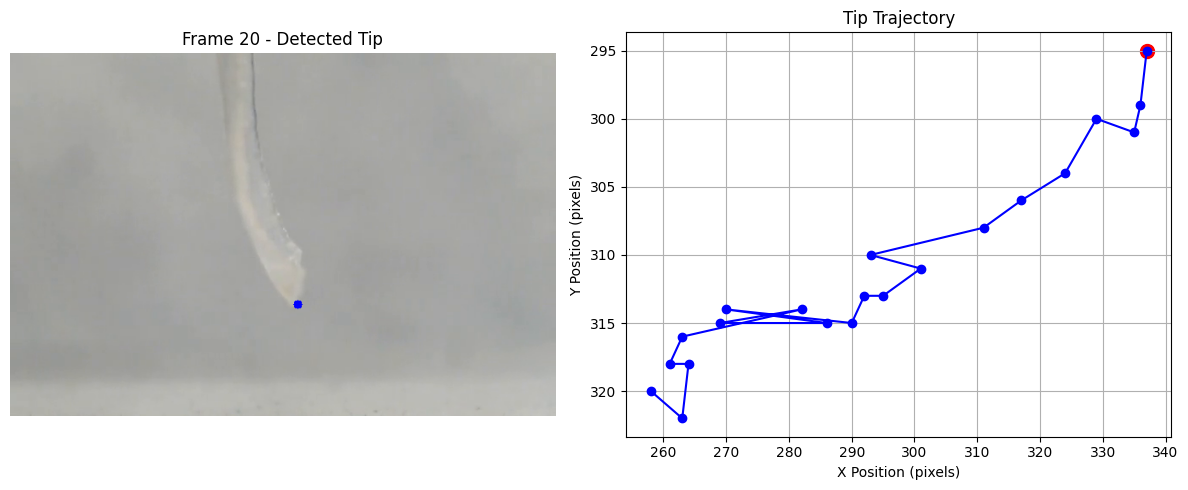


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_022.png: 1024x1024 1 0, 333.0ms
Speed: 4.9ms preprocess, 333.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
12867 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_023.png: 1024x1024 1 0, 333.1ms
Speed: 3.0ms preprocess, 333.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
13239 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_024.png: 1024x1024 1 0, 332.0ms
Speed: 3.1ms preprocess, 332.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
14202 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_025.png: 1024x1024 1 0, 328.4ms
Speed: 3.0ms preprocess, 328.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
15040 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_026.png: 1024x

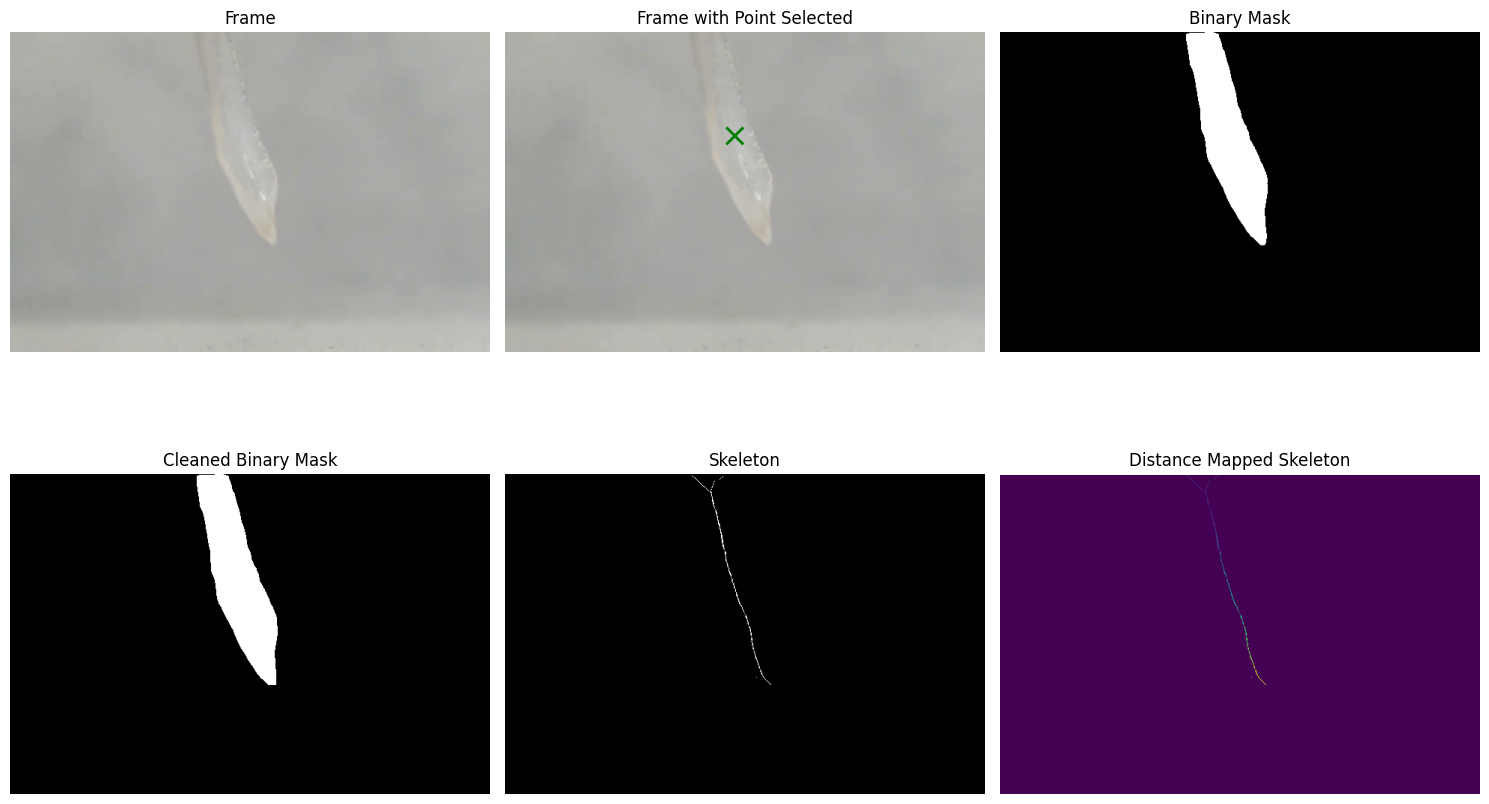

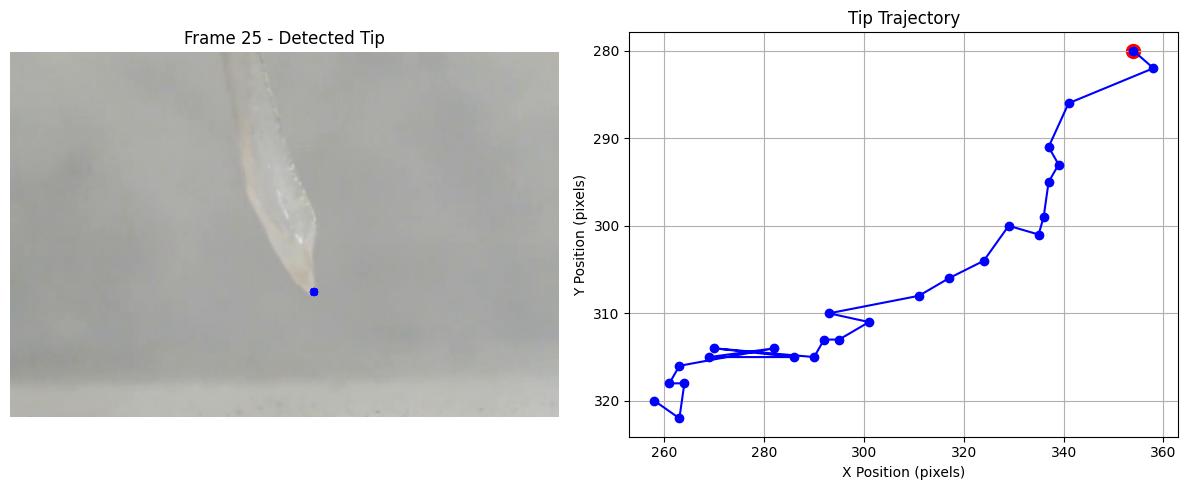


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_027.png: 1024x1024 1 0, 328.4ms
Speed: 4.8ms preprocess, 328.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
14558 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_028.png: 1024x1024 1 0, 342.9ms
Speed: 3.1ms preprocess, 342.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
14984 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_029.png: 1024x1024 1 0, 325.3ms
Speed: 3.1ms preprocess, 325.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
14945 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_030.png: 1024x1024 1 0, 326.2ms
Speed: 3.1ms preprocess, 326.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
14128 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_031.png: 1024x

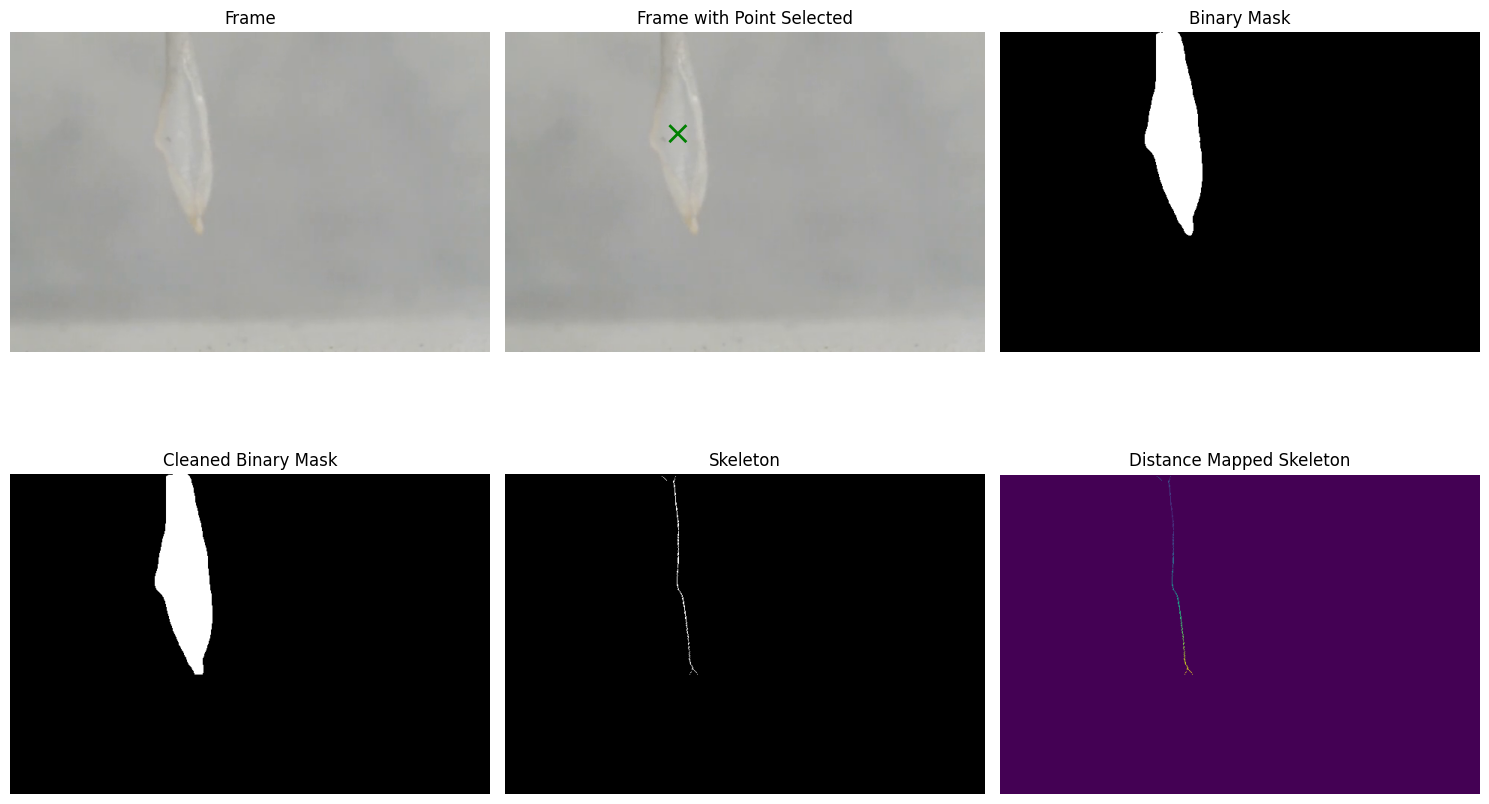

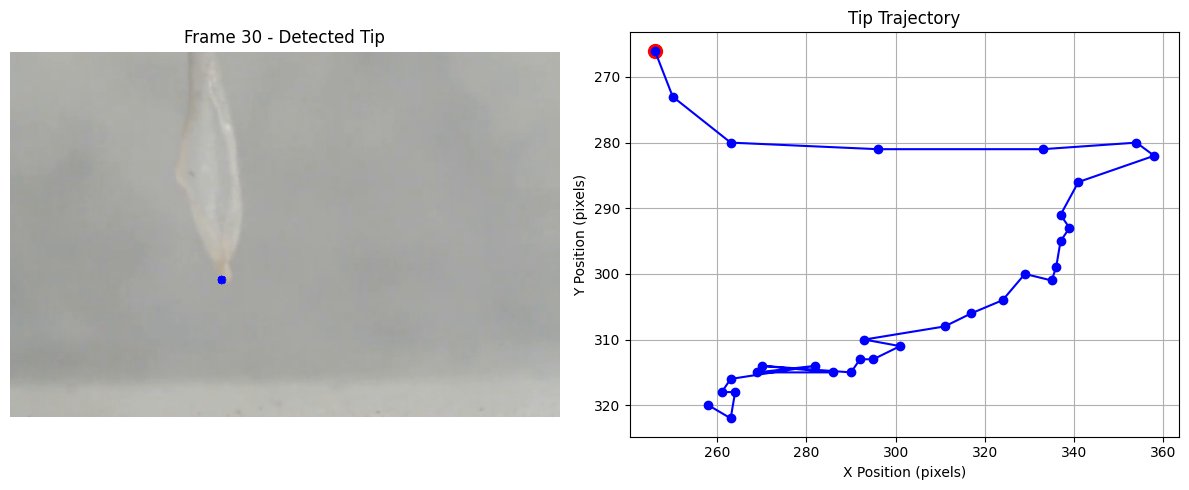


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_032.png: 1024x1024 1 0, 349.3ms
Speed: 4.9ms preprocess, 349.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
11675 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_033.png: 1024x1024 1 0, 337.1ms
Speed: 3.5ms preprocess, 337.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
9838 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_034.png: 1024x1024 1 0, 334.1ms
Speed: 3.1ms preprocess, 334.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
7919 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_035.png: 1024x1024 1 0, 334.2ms
Speed: 3.1ms preprocess, 334.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
6793 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_036.png: 1024x102

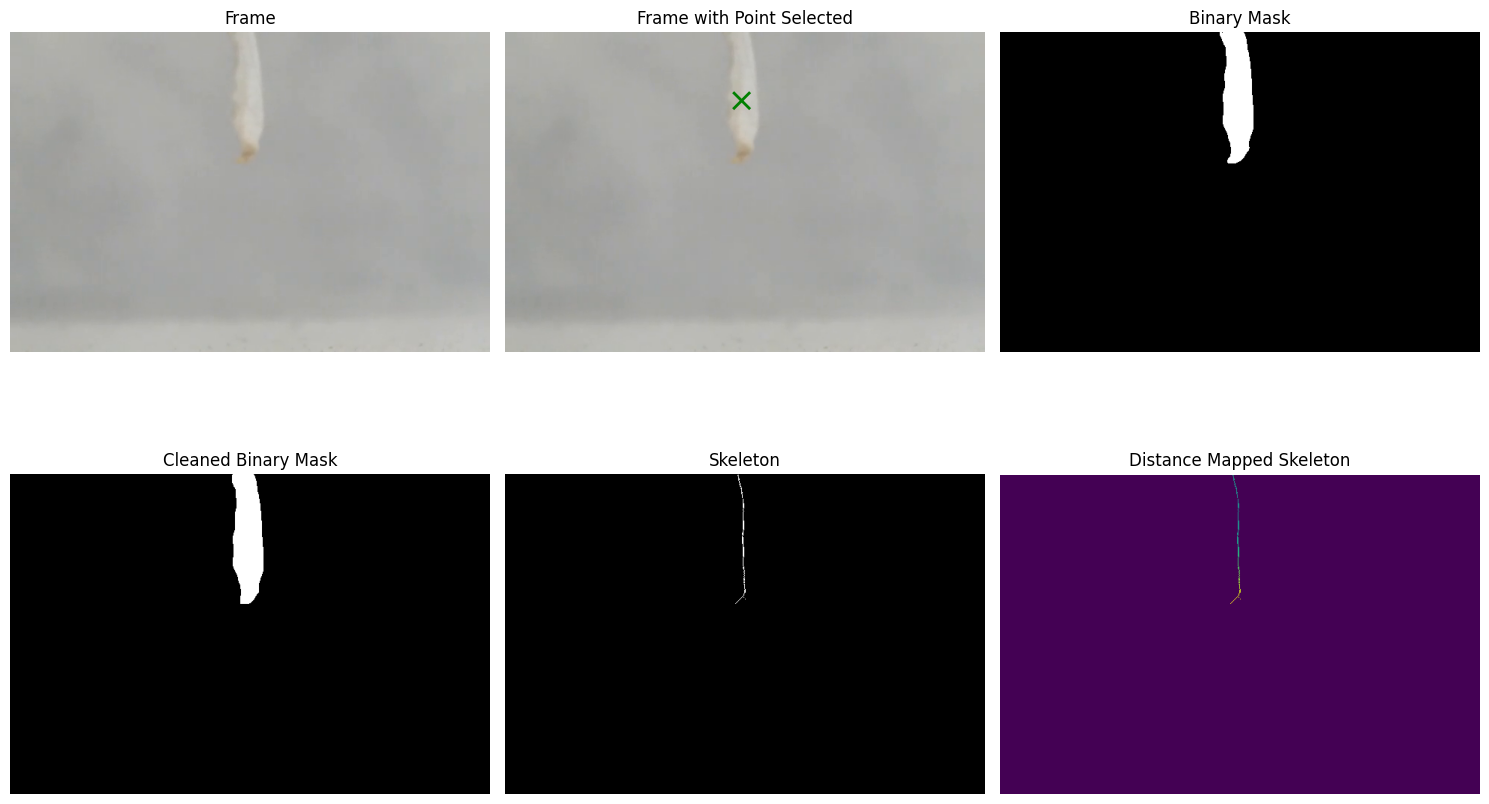

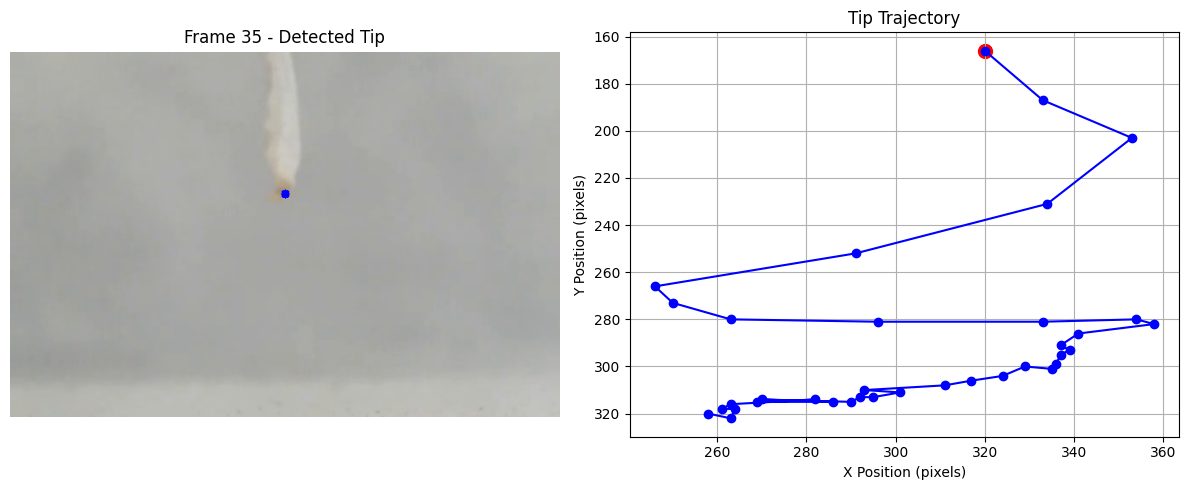

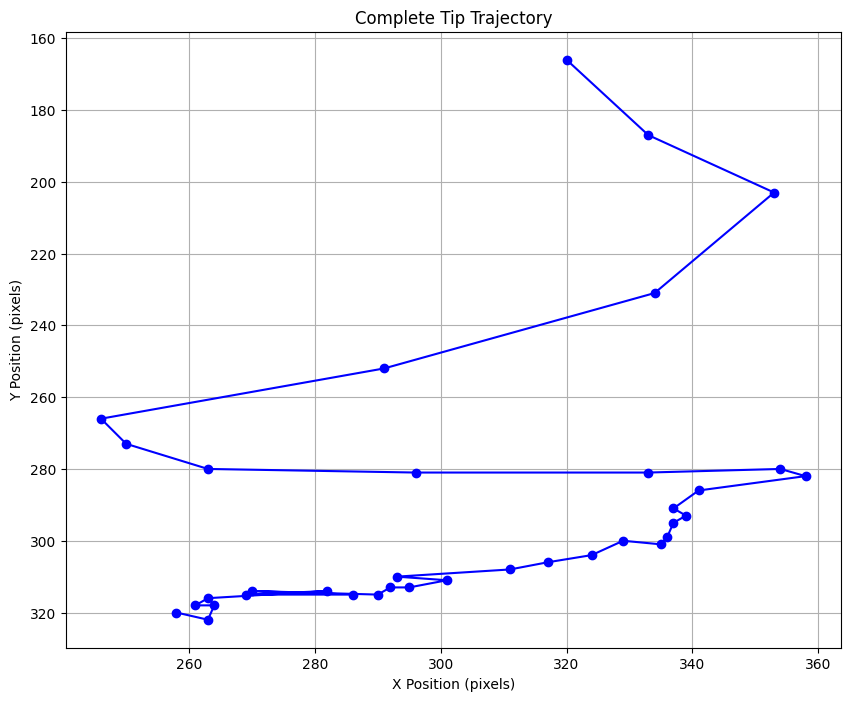

In [61]:
# Set paths
video_name = f"control_idx4_100x" # without the .mov
video_path = f"bimorph_videos/{video_name}.mov"
temp_folder = "tracking_frames/"
start_frame = 0
end_frame = 36
frame_interval=0.6
point = (255, 50)

extract_frames(video_path, temp_folder, interval=frame_interval)

track_actuator_tip(
    frame_folder=temp_folder,
    start_frame=start_frame,
    end_frame=end_frame,
    output_file=f"tracked_trajectories/{video_name}_tracked.csv",
    json_output_file=f"tracked_trajectories/{video_name}_json.csv",
    anchor_point=point,
    maximum_tip_travel_between_frames = 300,
    edge_cushion =0,
    tip_margin=40,
    wandering_point_top = 0,
    wandering_point_bottpm=300,
    debug=False,
    calculate_distance_relative_to_original_anchor=True
)


for filename in os.listdir(temp_folder):
    file_path = os.path.join(temp_folder, filename)
    if os.path.isdir(file_path):
        shutil.rmtree(file_path)
    else:
        os.remove(file_path)

In [62]:
# # Set paths
# video_name = f"control_idx5_100x" # without the .mp4
# video_path = f"bimorph_videos/{video_name}.mp4"
# temp_folder = "tracking_frames/"
# start_frame = 0
# #end_frame = 31
# frame_interval=0.6
# point = (285, 50)

# extract_frames(video_path, temp_folder, interval=frame_interval)

# track_actuator_tip(
#     frame_folder=temp_folder,
#     start_frame=start_frame,
#     end_frame=end_frame,
#     output_file=f"tracked_trajectories/{video_name}_tracked.csv",
#     json_output_file=f"tracked_trajectories/{video_name}_json.csv",
#     anchor_point=point,
#     maximum_tip_travel_between_frames = 140,
#     edge_cushion =0,
#     tip_margin=40
# )


# for filename in os.listdir(temp_folder):
#     file_path = os.path.join(temp_folder, filename)
#     if os.path.isdir(file_path):
#         shutil.rmtree(file_path)
#     else:
#         os.remove(file_path)

In [63]:
# # Set paths
# video_name = f"bimorph_idx0_100x" # without the .mov
# video_path = f"bimorph_videos/{video_name}.mov"
# temp_folder = "tracking_frames/"
# start_frame = 22
# end_frame = None
# frame_interval=0.6
# point = (260, 100)

# extract_frames(video_path, temp_folder, interval=frame_interval)

# track_actuator_tip(
#     frame_folder=temp_folder,
#     start_frame=start_frame,
#     end_frame=end_frame,
#     output_file=f"tracked_trajectories/{video_name}_tracked.csv",
#     json_output_file=f"tracked_trajectories/{video_name}_json.csv",
#     anchor_point=point,
# )


# for filename in os.listdir(temp_folder):
#     file_path = os.path.join(temp_folder, filename)
#     if os.path.isdir(file_path):
#         shutil.rmtree(file_path)
#     else:
#         os.remove(file_path)

In [64]:
# # Set paths
# video_name = f"bimorph_idx1_100x" # without the .mov
# video_path = f"bimorph_videos/{video_name}.mov"
# temp_folder = "tracking_frames/"
# start_frame = 0
# end_frame = 40
# frame_interval=0.6
# point = (190, 30)

# extract_frames(video_path, temp_folder, interval=frame_interval)

# track_actuator_tip(
#     frame_folder=temp_folder,
#     start_frame=start_frame,
#     end_frame=end_frame,
#     output_file=f"tracked_trajectories/{video_name}_tracked.csv",
#     json_output_file=f"tracked_trajectories/{video_name}_json.csv",
#     anchor_point=point,
#     edge_cushion =0,
#     no_wandering_anchor=True,
# )


# for filename in os.listdir(temp_folder):
#     file_path = os.path.join(temp_folder, filename)
#     if os.path.isdir(file_path):
#         shutil.rmtree(file_path)
#     else:
#         os.remove(file_path)

In [65]:
# # Set paths
# video_name = f"bimorph_idx2_100x" # without the .mov
# video_path = f"bimorph_videos/{video_name}.mov"
# temp_folder = "tracking_frames/"
# start_frame = 25
# end_frame = 100
# frame_interval=0.6
# point = (220, 50)

# extract_frames(video_path, temp_folder, interval=frame_interval)

# track_actuator_tip(
#     frame_folder=temp_folder,
#     start_frame=start_frame,
#     end_frame=end_frame,
#     output_file=f"tracked_trajectories/{video_name}_tracked.csv",
#     json_output_file=f"tracked_trajectories/{video_name}_json.csv",
#     anchor_point=point,
#     edge_cushion =0,
#     tip_margin=20, # boosting the tip margin since there are a few points with similar distance in the skeleton
#     no_wandering_anchor=True,
# )


# for filename in os.listdir(temp_folder):
#     file_path = os.path.join(temp_folder, filename)
#     if os.path.isdir(file_path):
#         shutil.rmtree(file_path)
#     else:
#         os.remove(file_path)

In [66]:
# # Set paths
# video_name = f"bimorph_idx3_100x" 
# video_path = f"bimorph_videos/{video_name}.mov"
# temp_folder = "tracking_frames/"
# start_frame = 0
# end_frame = 35
# frame_interval=0.6
# point = (310, 50)

# extract_frames(video_path, temp_folder, interval=frame_interval)

# track_actuator_tip(
#     frame_folder=temp_folder,
#     start_frame=start_frame,
#     end_frame=end_frame,
#     output_file=f"tracked_trajectories/{video_name}_tracked.csv",
#     json_output_file=f"tracked_trajectories/{video_name}_json.csv",
#     anchor_point=point,
#     edge_cushion =0,
#     opening_kernel=(3,3)
# )

# for filename in os.listdir(temp_folder):
#     file_path = os.path.join(temp_folder, filename)
#     if os.path.isdir(file_path):
#         shutil.rmtree(file_path)
#     else:
#         os.remove(file_path)

Analyzing frames 0 to 33
Total frames used: 34



ffmpeg version 6.1.1-3ubuntu5 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13 (Ubuntu 13.2.0-23ubuntu3)
  configuration: --prefix=/usr --extra-version=3ubuntu5 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --disable-omx --enable-gnutls --enable-libaom --enable-libass --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libharfbuzz --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-libzimg --ena

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_001.png: 1024x1024 1 0, 332.0ms
Speed: 3.0ms preprocess, 332.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
740 0 640


<Figure size 1200x1000 with 0 Axes>

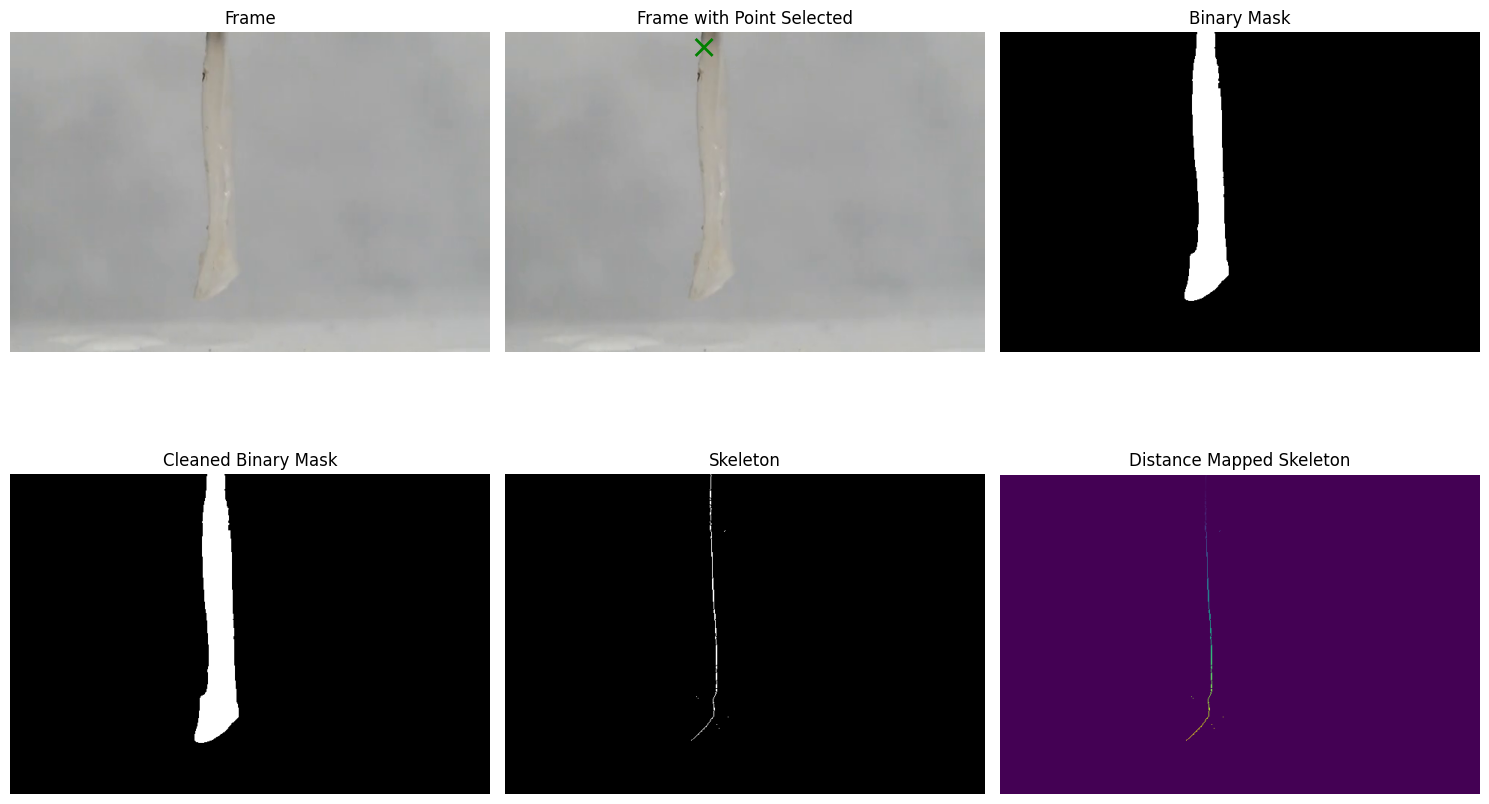

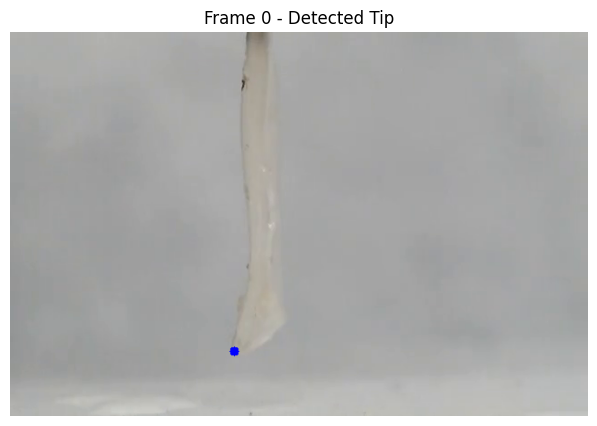


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_002.png: 1024x1024 1 0, 346.2ms
Speed: 3.5ms preprocess, 346.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
702 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_003.png: 1024x1024 1 0, 333.5ms
Speed: 3.1ms preprocess, 333.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
814 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_004.png: 1024x1024 1 0, 336.0ms
Speed: 3.1ms preprocess, 336.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
817 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_005.png: 1024x1024 1 0, 334.2ms
Speed: 3.0ms preprocess, 334.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
790 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_006.png: 1024x1024 1 0

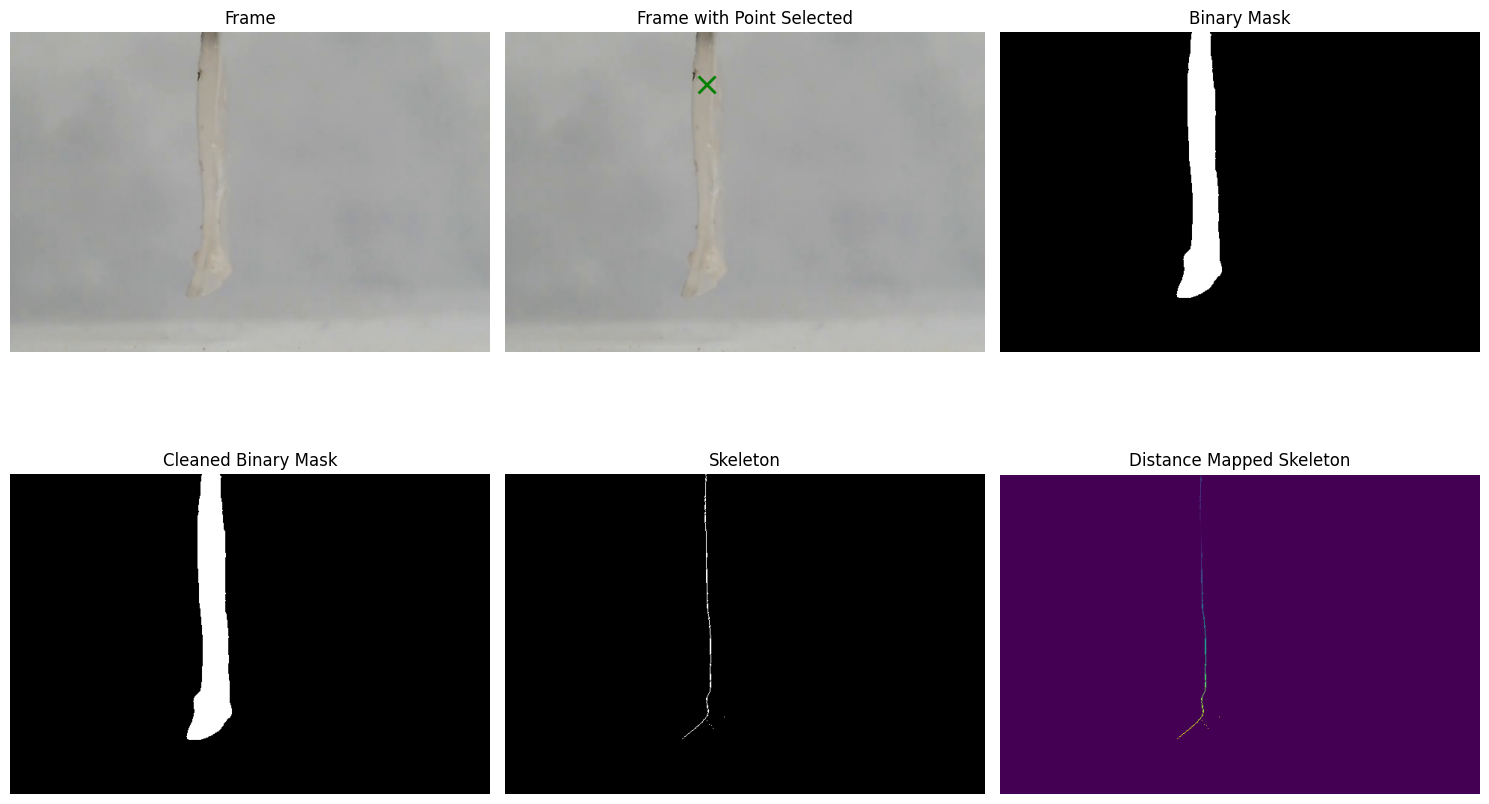

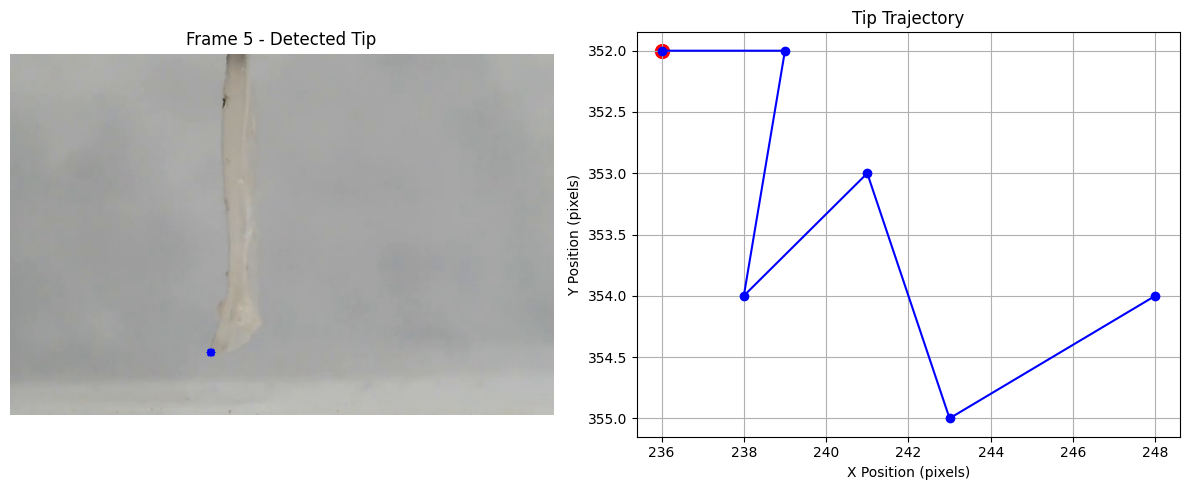


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_007.png: 1024x1024 1 0, 361.7ms
Speed: 4.9ms preprocess, 361.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
727 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_008.png: 1024x1024 1 0, 336.0ms
Speed: 3.1ms preprocess, 336.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
725 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_009.png: 1024x1024 1 0, 332.4ms
Speed: 3.0ms preprocess, 332.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
704 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_010.png: 1024x1024 1 0, 339.4ms
Speed: 3.0ms preprocess, 339.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
700 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_011.png: 1024x1024 1 0

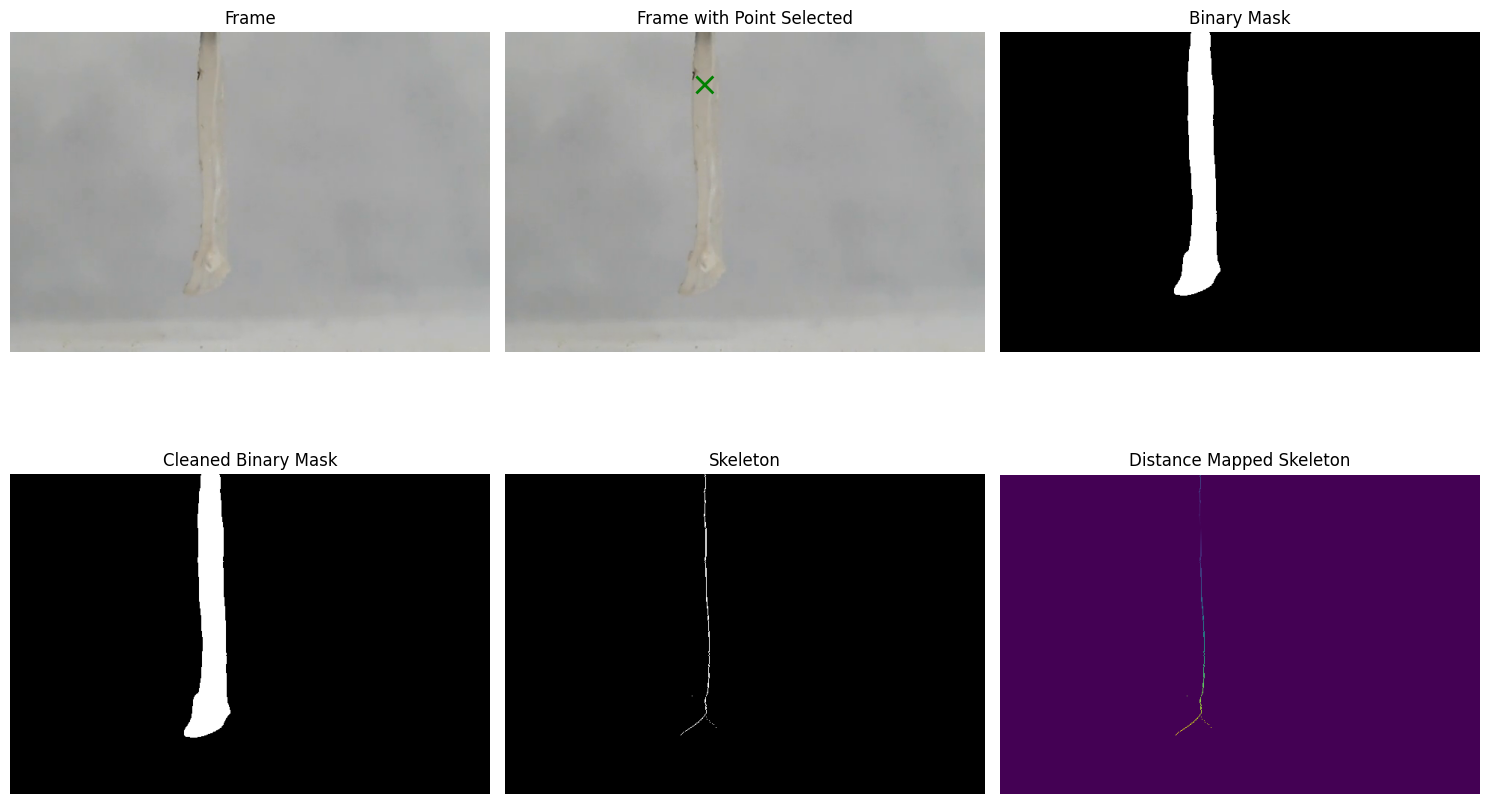

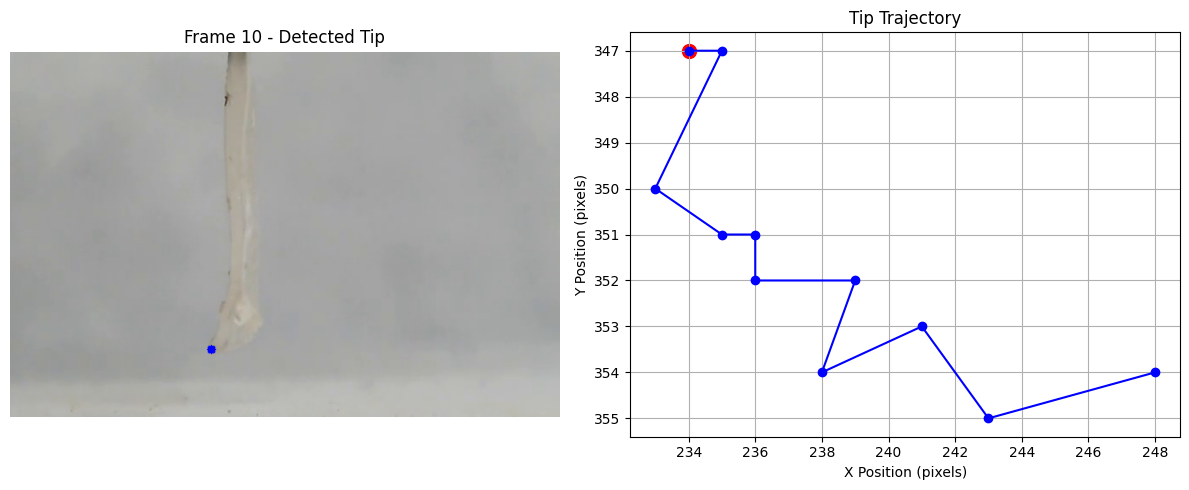


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_012.png: 1024x1024 1 0, 340.4ms
Speed: 4.9ms preprocess, 340.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
671 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_013.png: 1024x1024 1 0, 342.4ms
Speed: 4.6ms preprocess, 342.4ms inference, 0.5ms postprocess per image at shape (1, 3, 1024, 1024)
673 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_014.png: 1024x1024 1 0, 336.3ms
Speed: 3.1ms preprocess, 336.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
634 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_015.png: 1024x1024 1 0, 335.0ms
Speed: 3.2ms preprocess, 335.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
692 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_016.png: 1024x1024 1 0

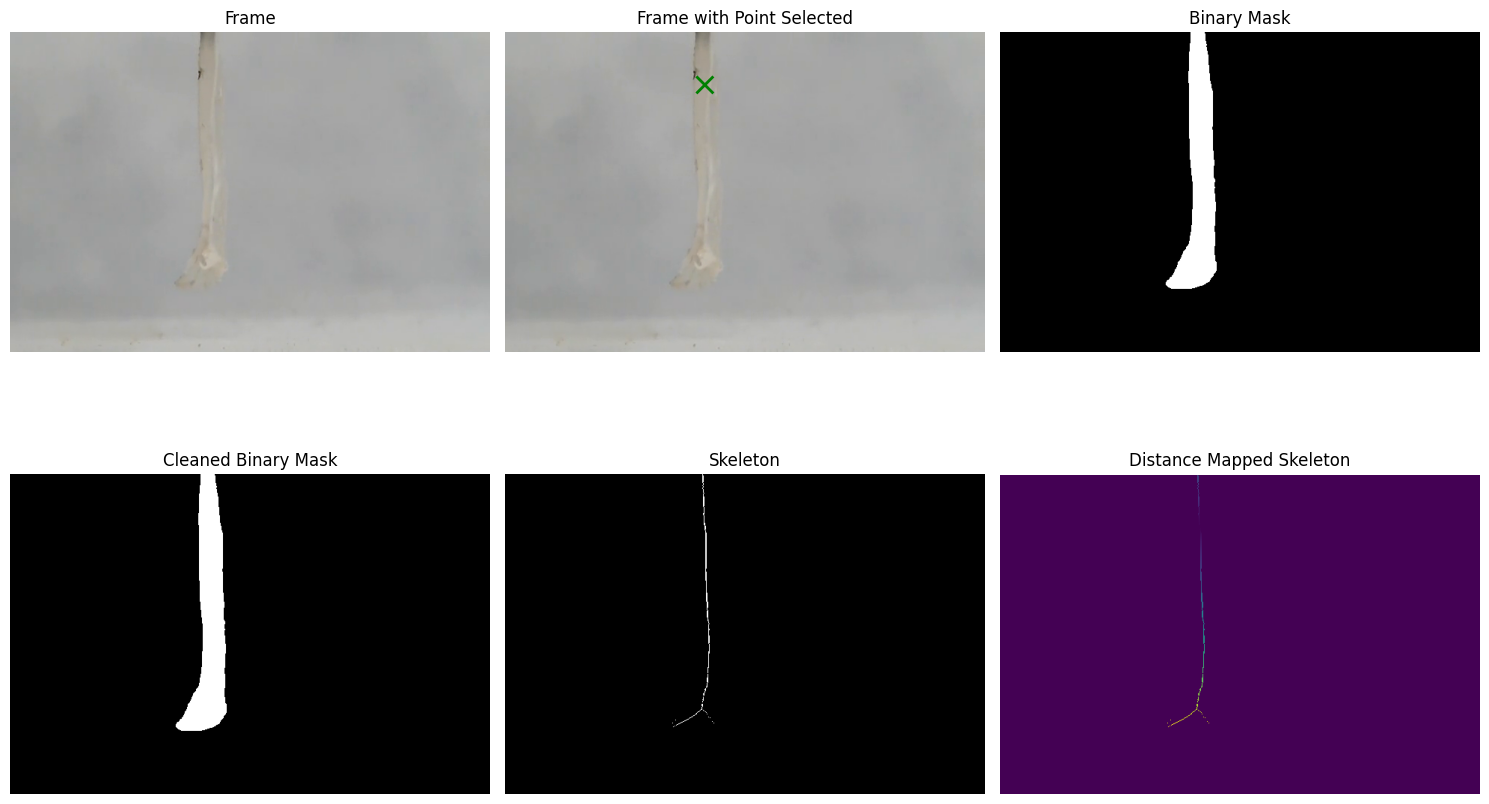

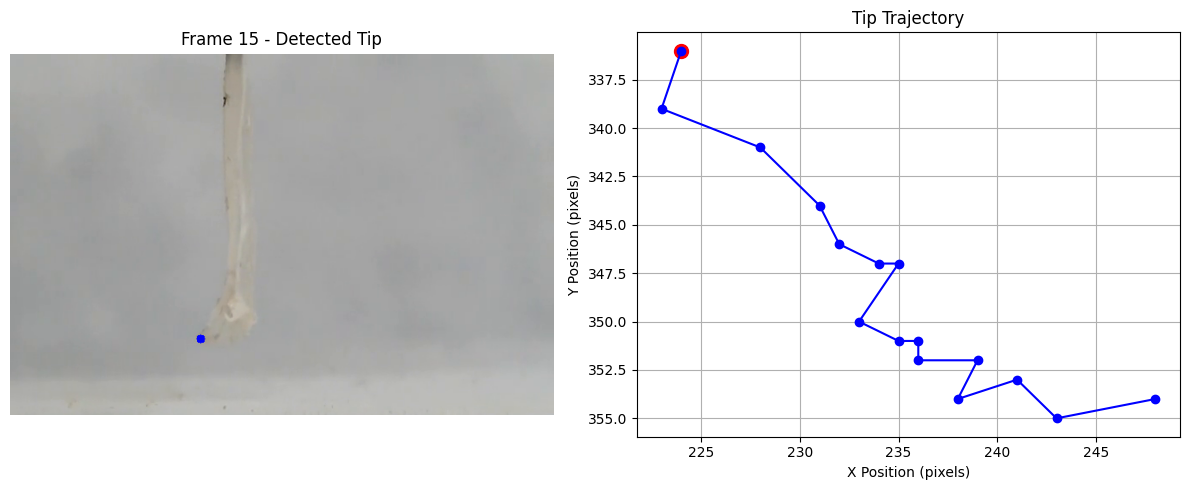


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_017.png: 1024x1024 1 0, 334.8ms
Speed: 4.8ms preprocess, 334.8ms inference, 0.5ms postprocess per image at shape (1, 3, 1024, 1024)
627 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_018.png: 1024x1024 1 0, 344.2ms
Speed: 3.2ms preprocess, 344.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
596 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_019.png: 1024x1024 1 0, 335.8ms
Speed: 3.0ms preprocess, 335.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
555 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_020.png: 1024x1024 1 0, 333.9ms
Speed: 3.1ms preprocess, 333.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
534 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_021.png: 1024x1024 1 0

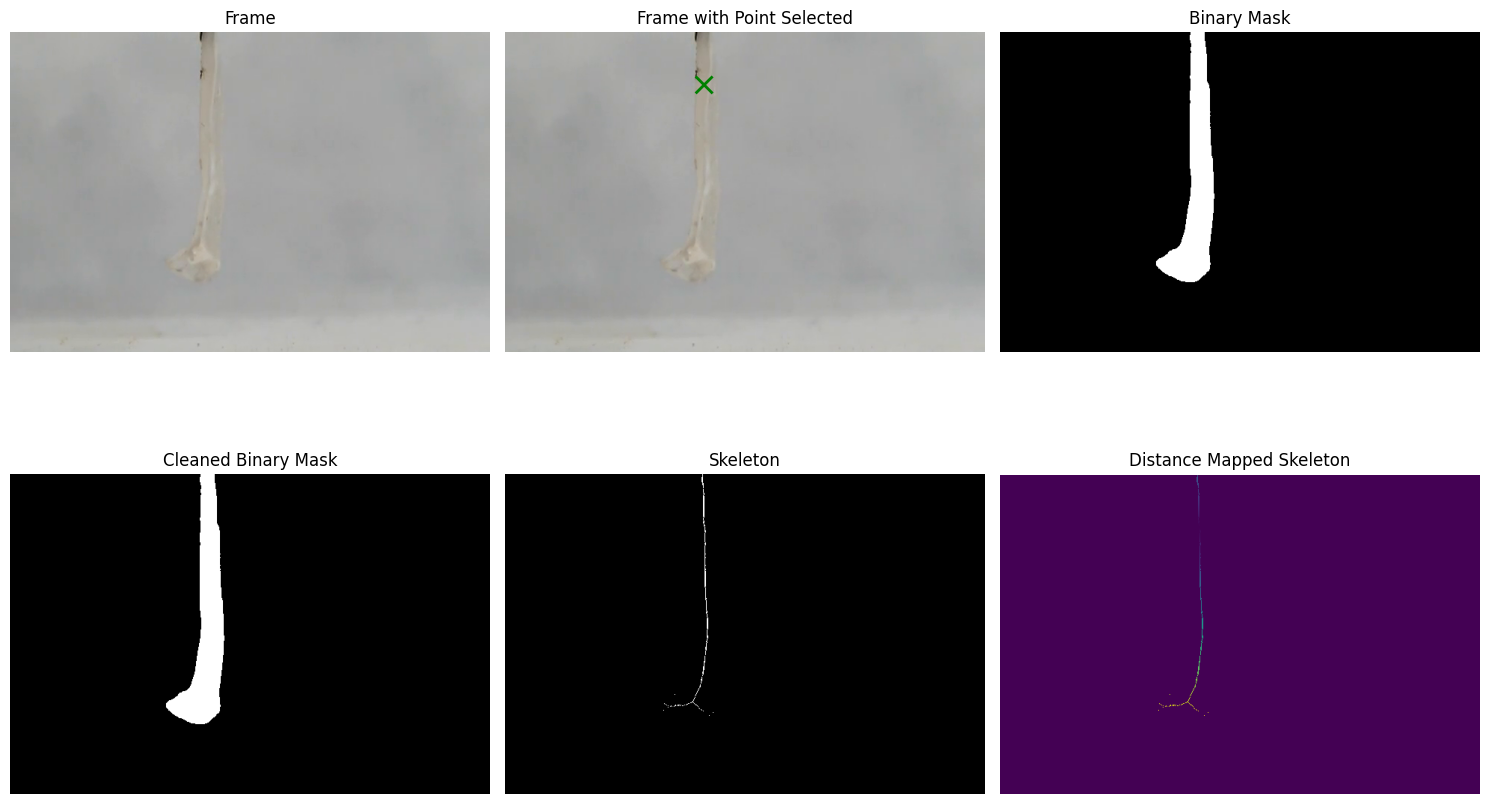

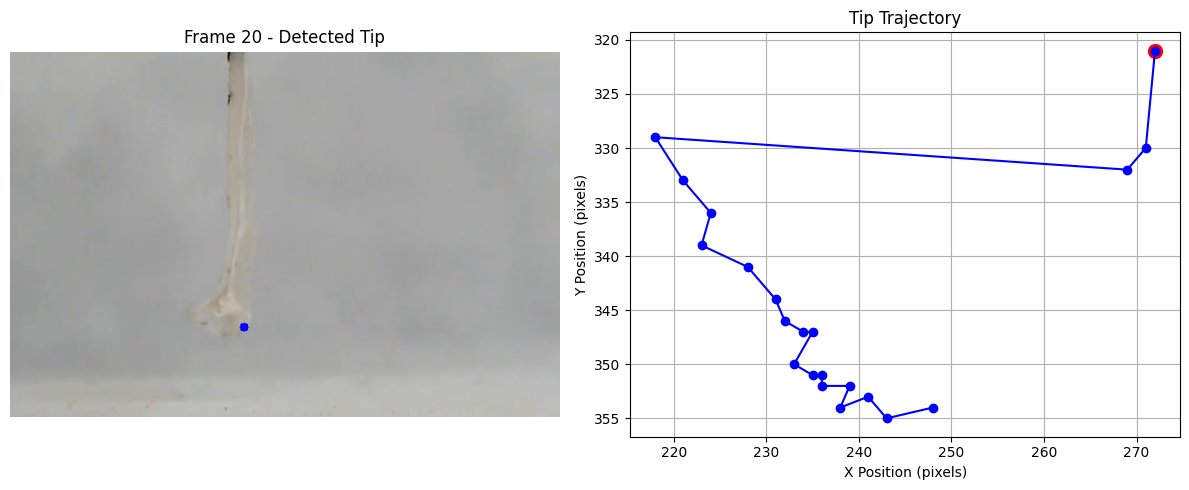


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_022.png: 1024x1024 1 0, 334.7ms
Speed: 3.1ms preprocess, 334.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
463 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_023.png: 1024x1024 1 0, 340.4ms
Speed: 3.1ms preprocess, 340.4ms inference, 0.6ms postprocess per image at shape (1, 3, 1024, 1024)
476 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_024.png: 1024x1024 1 0, 332.5ms
Speed: 3.1ms preprocess, 332.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
473 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_025.png: 1024x1024 1 0, 334.1ms
Speed: 3.0ms preprocess, 334.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
468 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_026.png: 1024x1024 1 0

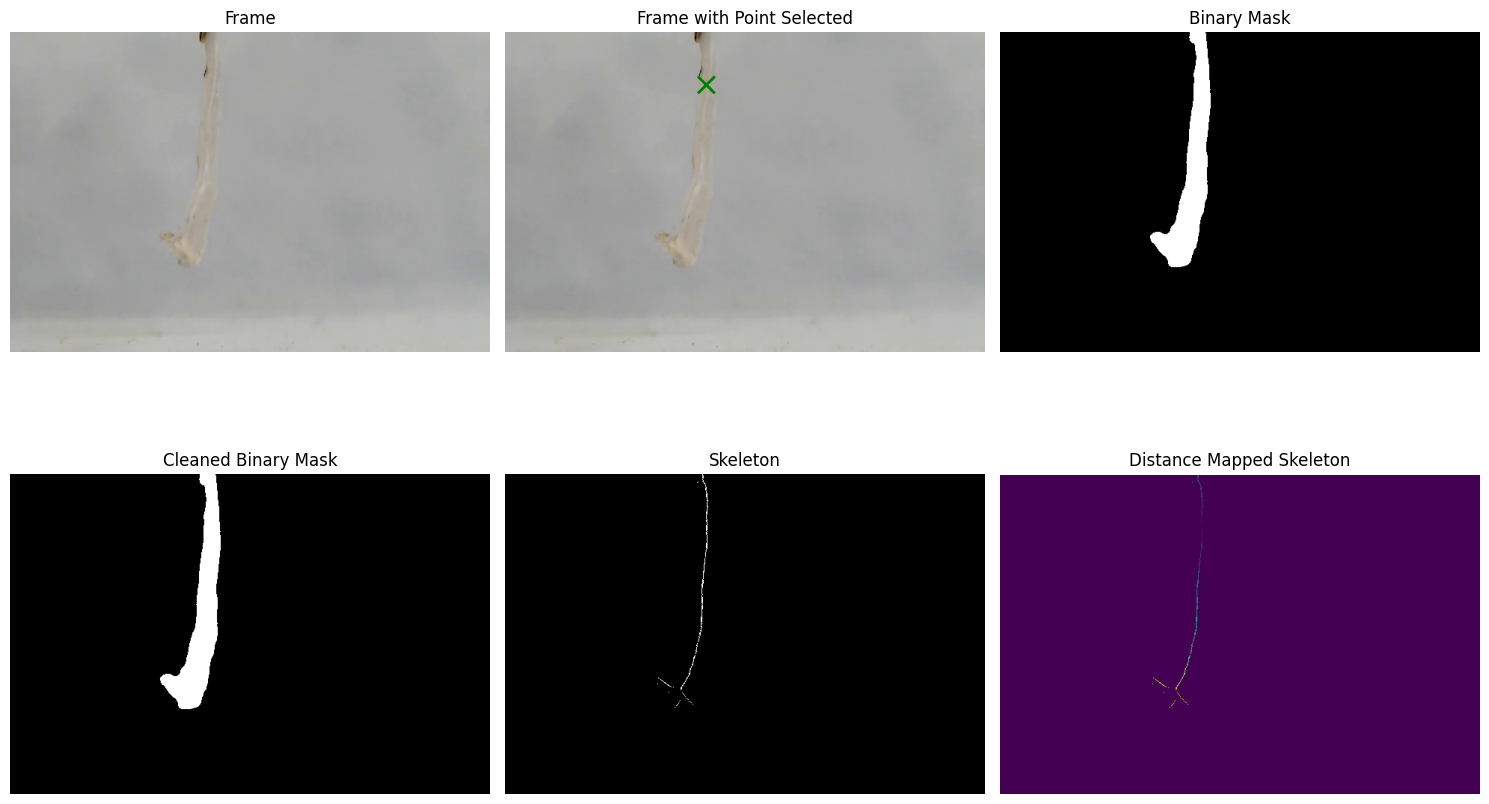

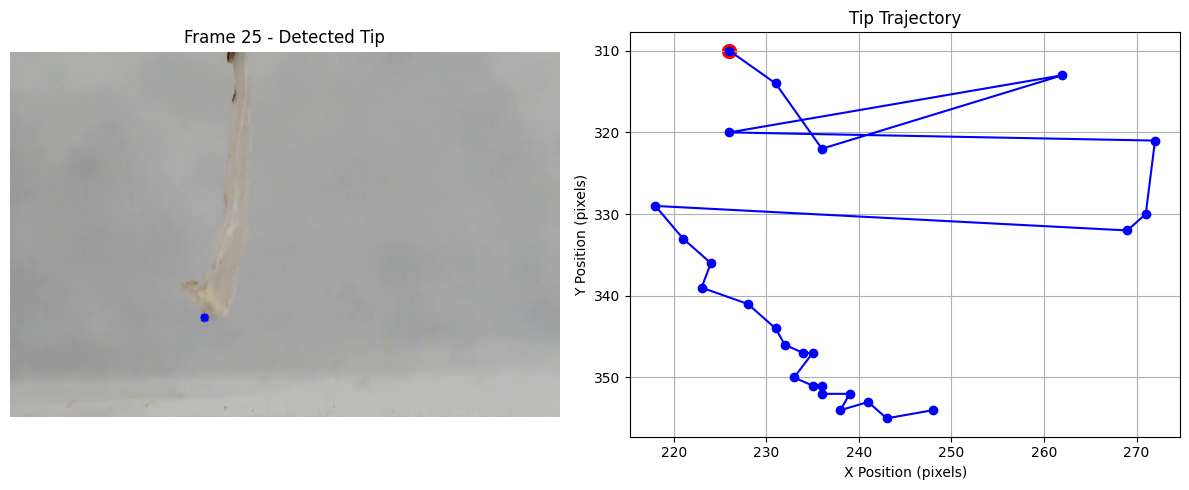


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_027.png: 1024x1024 1 0, 335.0ms
Speed: 4.8ms preprocess, 335.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
397 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_028.png: 1024x1024 1 0, 340.7ms
Speed: 3.0ms preprocess, 340.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
325 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_029.png: 1024x1024 1 0, 334.0ms
Speed: 3.1ms preprocess, 334.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
270 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_030.png: 1024x1024 1 0, 334.2ms
Speed: 3.0ms preprocess, 334.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
252 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_031.png: 1024x1024 1 0

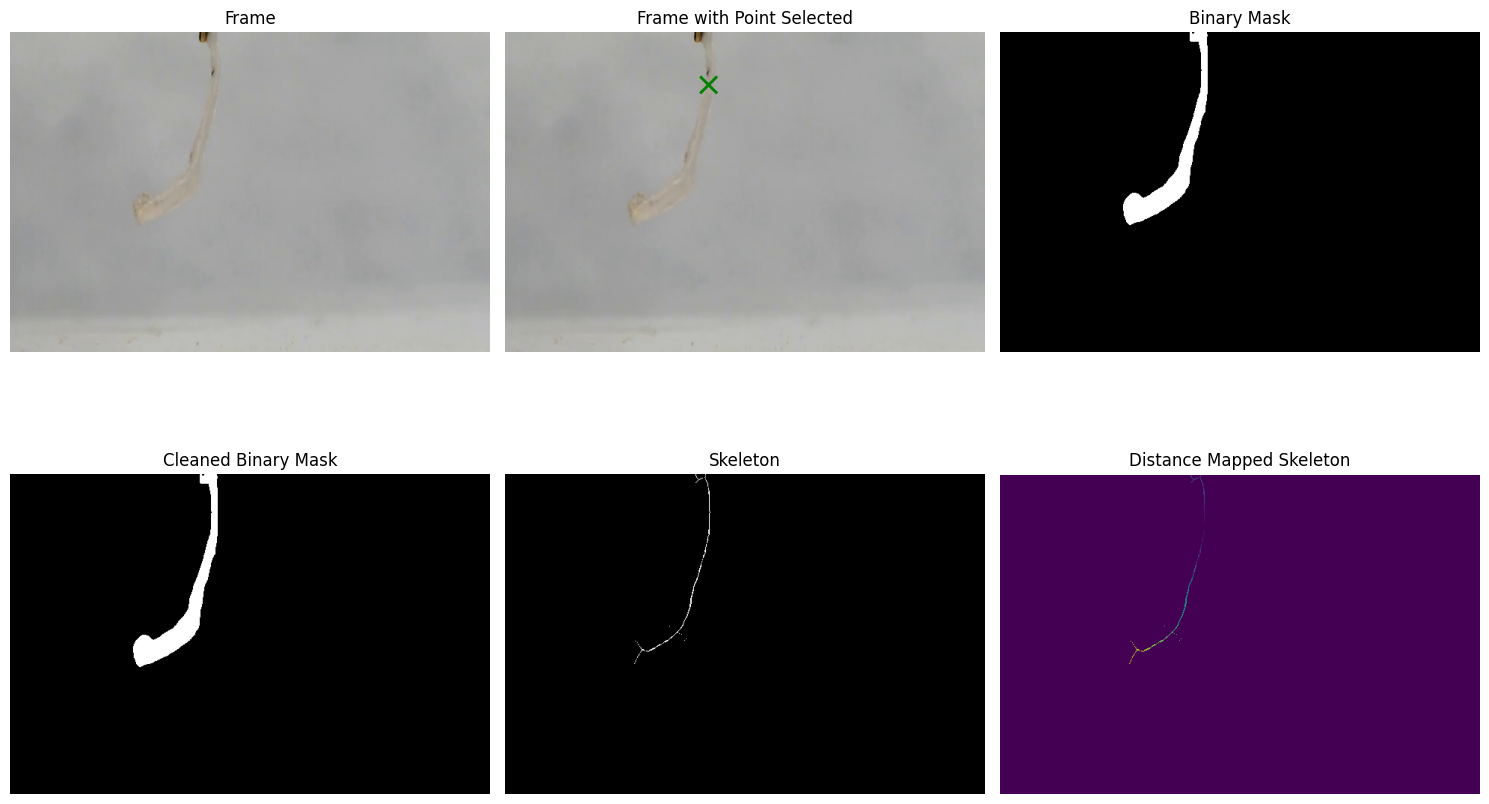

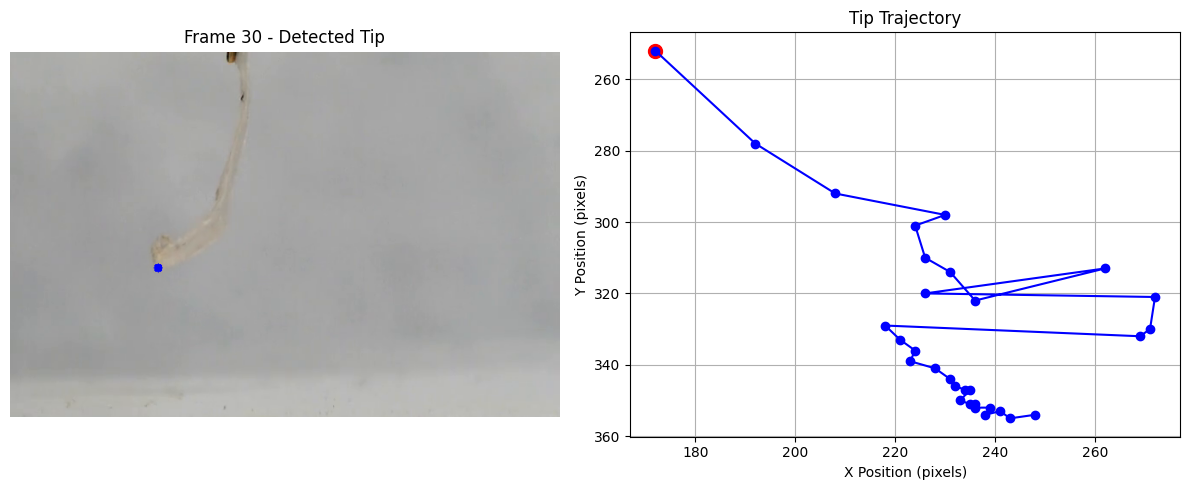


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_032.png: 1024x1024 1 0, 334.7ms
Speed: 4.9ms preprocess, 334.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
209 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_033.png: 1024x1024 1 0, 332.6ms
Speed: 3.1ms preprocess, 332.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
199 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_034.png: 1024x1024 1 0, 334.6ms
Speed: 3.1ms preprocess, 334.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
265 0 640


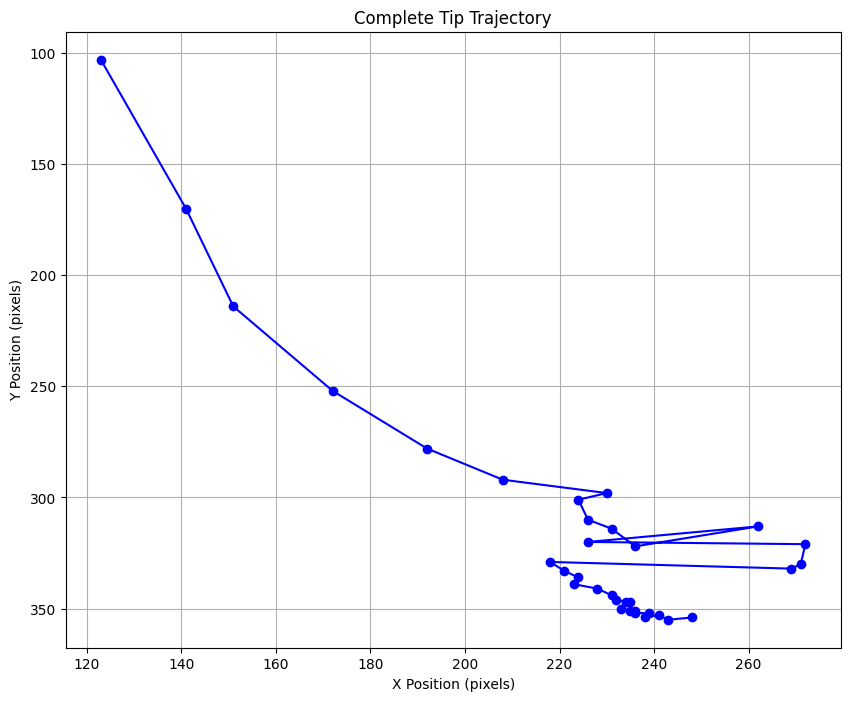

In [67]:
# Set paths
video_name = f"bimorph_idx4_100x" 
video_path = f"bimorph_videos/{video_name}.mp4"
temp_folder = "tracking_frames/"
start_frame = 0
end_frame = None
frame_interval=0.6
point = (265, 20)

extract_frames(video_path, temp_folder, interval=frame_interval)

track_actuator_tip(
    frame_folder=temp_folder,
    start_frame=start_frame,
    end_frame=end_frame,
    output_file=f"tracked_trajectories/{video_name}_tracked.csv",
    json_output_file=f"tracked_trajectories/{video_name}_json.csv",
    anchor_point=point,
    edge_cushion =0,
    maximum_tip_travel_between_frames = 150,
    tip_margin = 20,
    no_wandering_anchor=False,
    debug=False,
    wandering_point_bottpm=80,
    opening_kernel=(1,1)
)

for filename in os.listdir(temp_folder):
    file_path = os.path.join(temp_folder, filename)
    if os.path.isdir(file_path):
        shutil.rmtree(file_path)
    else:
        os.remove(file_path)

Analyzing frames 0 to 37
Total frames used: 38



ffmpeg version 6.1.1-3ubuntu5 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13 (Ubuntu 13.2.0-23ubuntu3)
  configuration: --prefix=/usr --extra-version=3ubuntu5 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --disable-omx --enable-gnutls --enable-libaom --enable-libass --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libharfbuzz --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-libzimg --ena

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_001.png: 1024x1024 1 0, 334.2ms
Speed: 3.1ms preprocess, 334.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)
913 0 640


<Figure size 1200x1000 with 0 Axes>

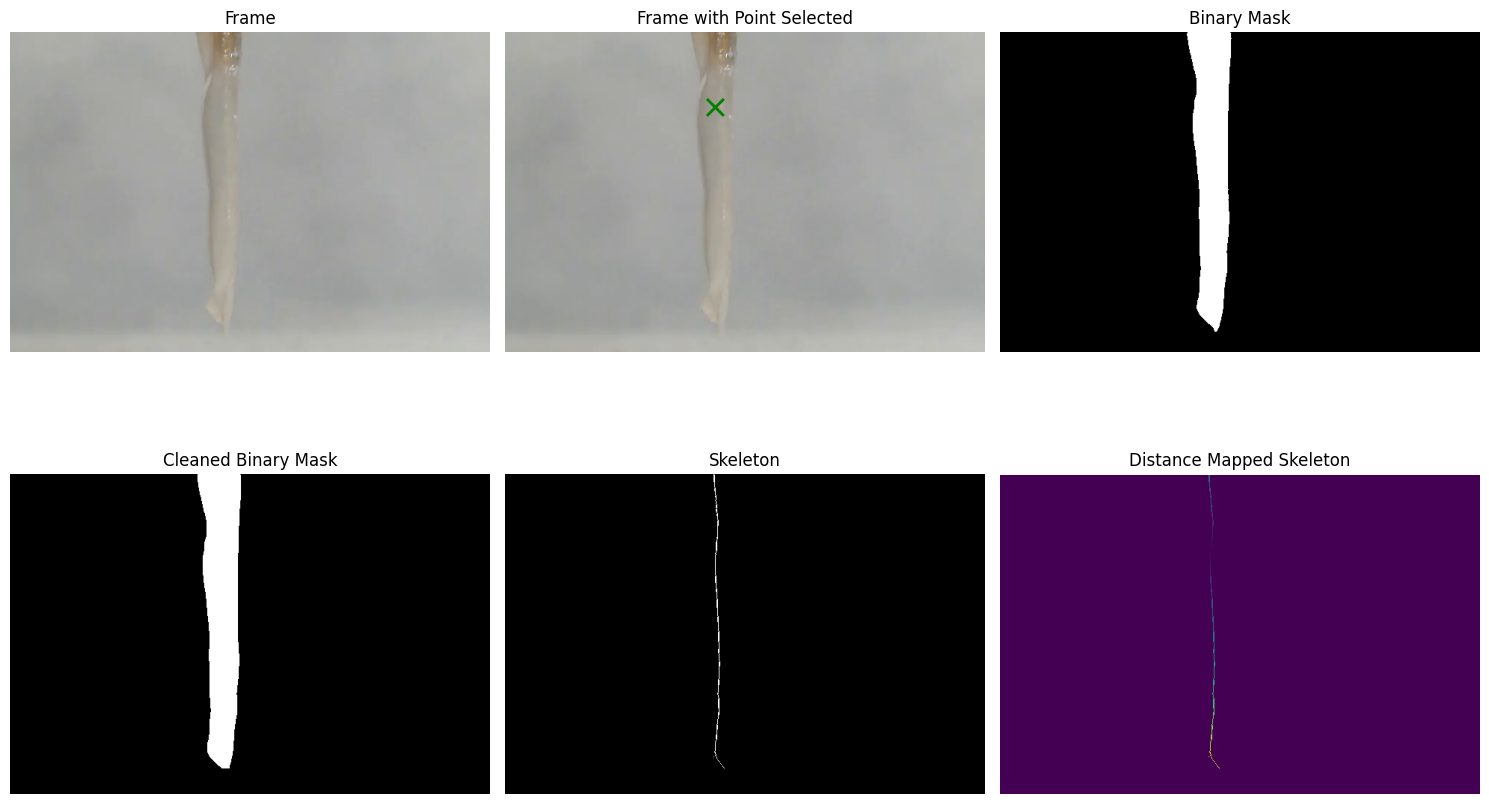

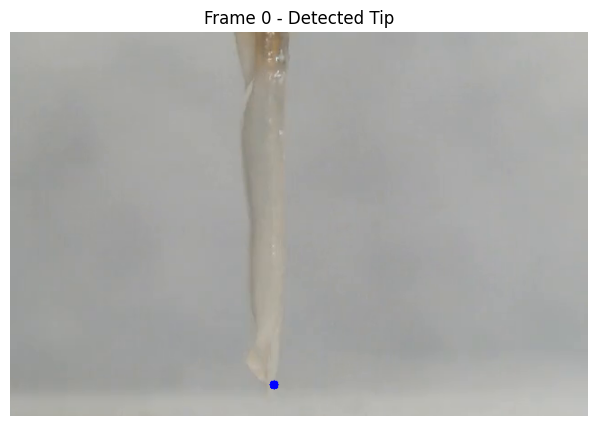


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_002.png: 1024x1024 1 0, 340.3ms
Speed: 4.9ms preprocess, 340.3ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)
904 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_003.png: 1024x1024 1 0, 334.1ms
Speed: 3.3ms preprocess, 334.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
919 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_004.png: 1024x1024 1 0, 335.3ms
Speed: 3.0ms preprocess, 335.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
880 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_005.png: 1024x1024 1 0, 335.1ms
Speed: 3.8ms preprocess, 335.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
888 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_006.png: 1024x1024 1 0

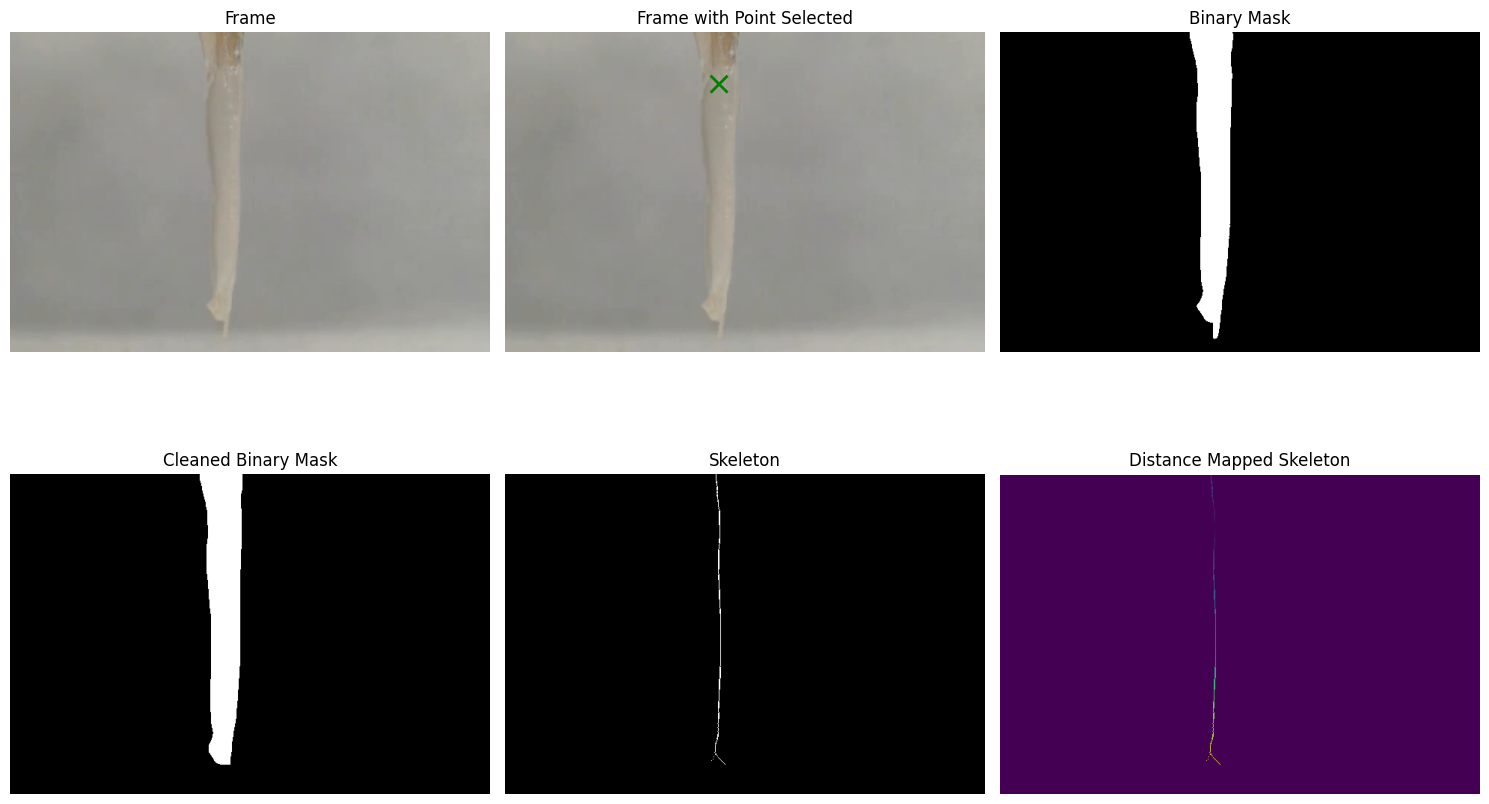

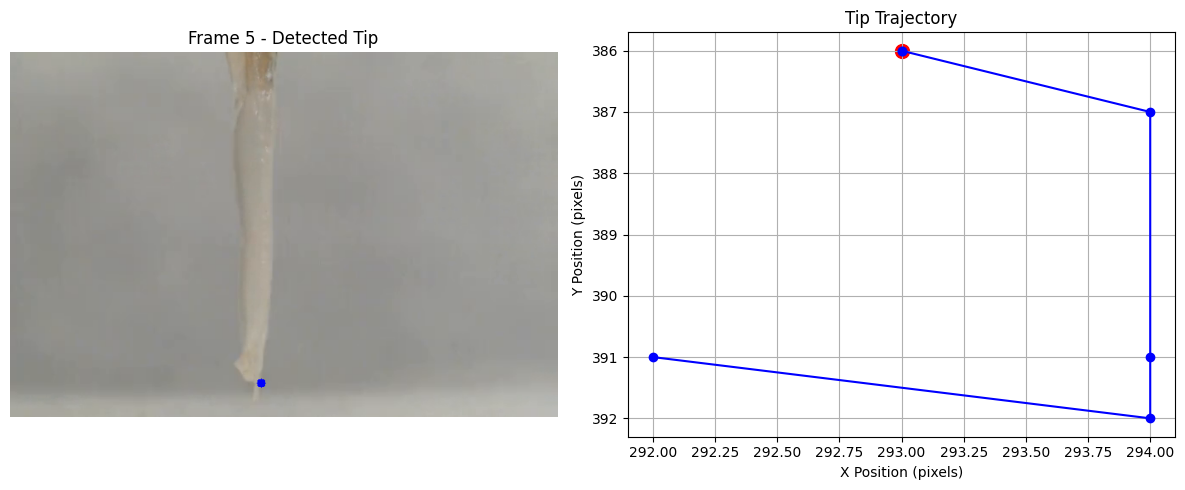


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_007.png: 1024x1024 1 0, 343.1ms
Speed: 4.8ms preprocess, 343.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
876 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_008.png: 1024x1024 1 0, 333.5ms
Speed: 3.0ms preprocess, 333.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
854 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_009.png: 1024x1024 1 0, 329.2ms
Speed: 3.0ms preprocess, 329.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
843 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_010.png: 1024x1024 1 0, 340.7ms
Speed: 3.1ms preprocess, 340.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
848 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_011.png: 1024x1024 1 0

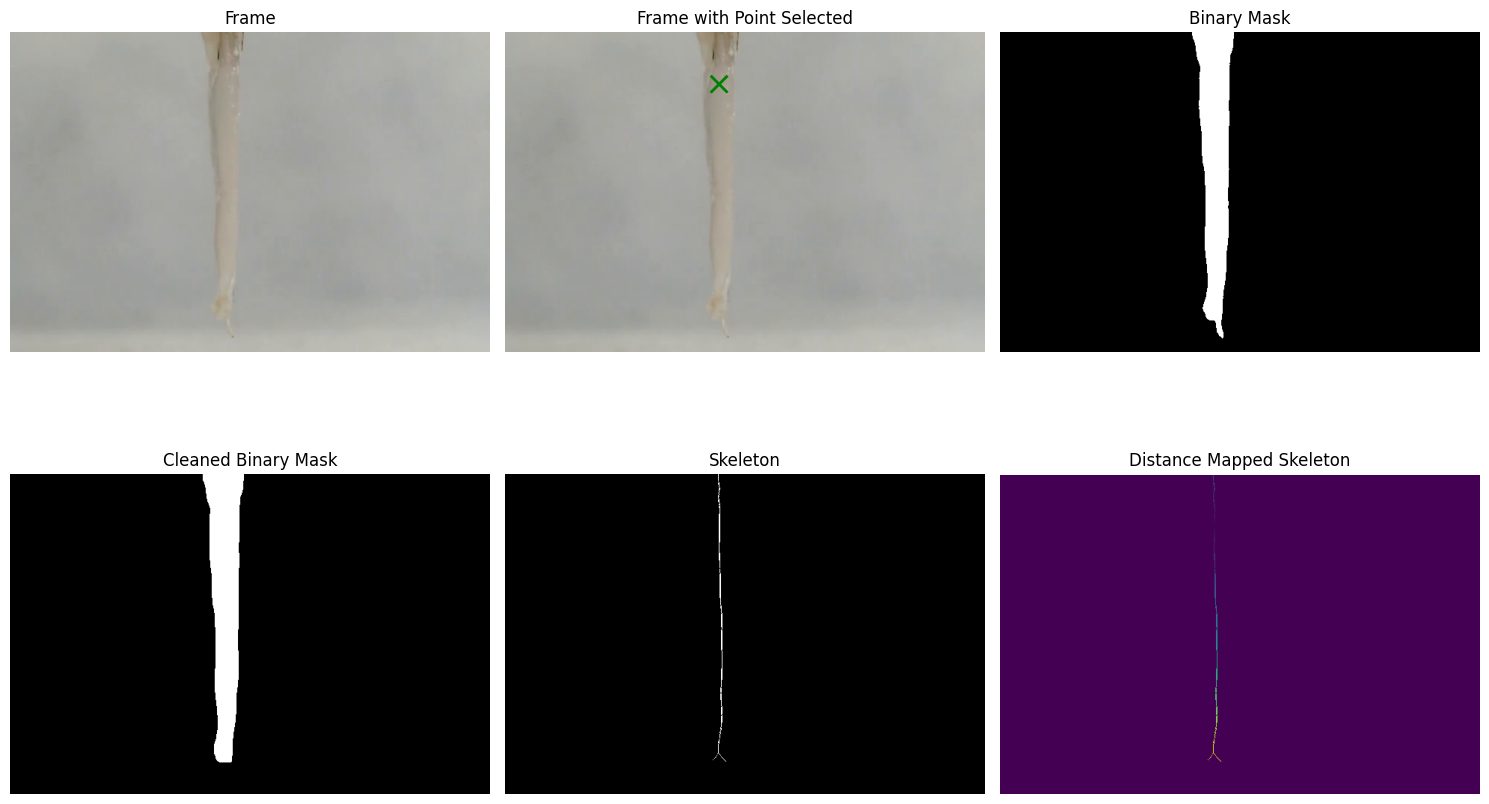

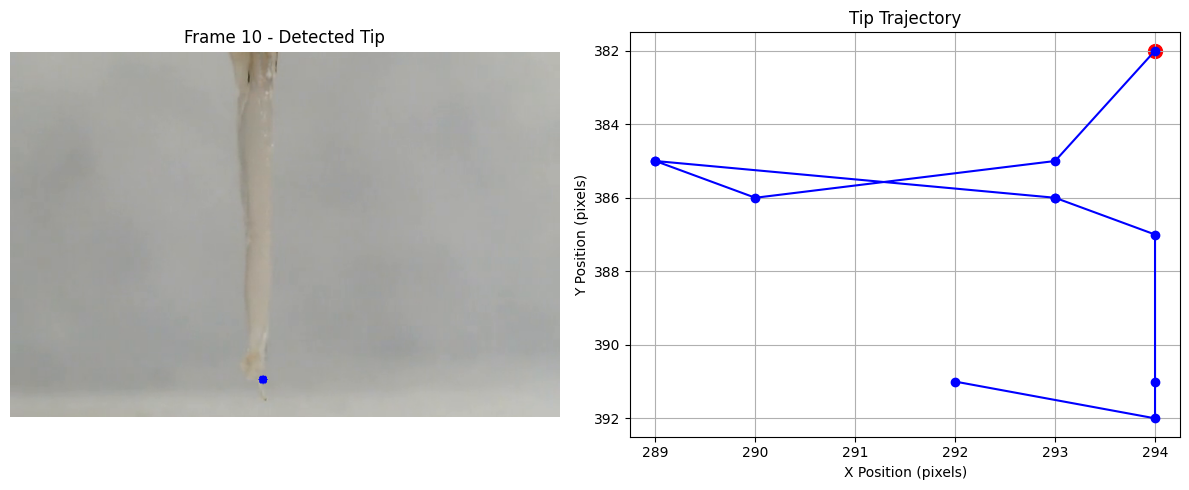


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_012.png: 1024x1024 1 0, 334.9ms
Speed: 5.4ms preprocess, 334.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
840 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_013.png: 1024x1024 1 0, 345.7ms
Speed: 3.0ms preprocess, 345.7ms inference, 0.5ms postprocess per image at shape (1, 3, 1024, 1024)
826 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_014.png: 1024x1024 1 0, 337.0ms
Speed: 3.0ms preprocess, 337.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
818 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_015.png: 1024x1024 1 0, 335.3ms
Speed: 3.0ms preprocess, 335.3ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 1024)
820 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_016.png: 1024x1024 1 0

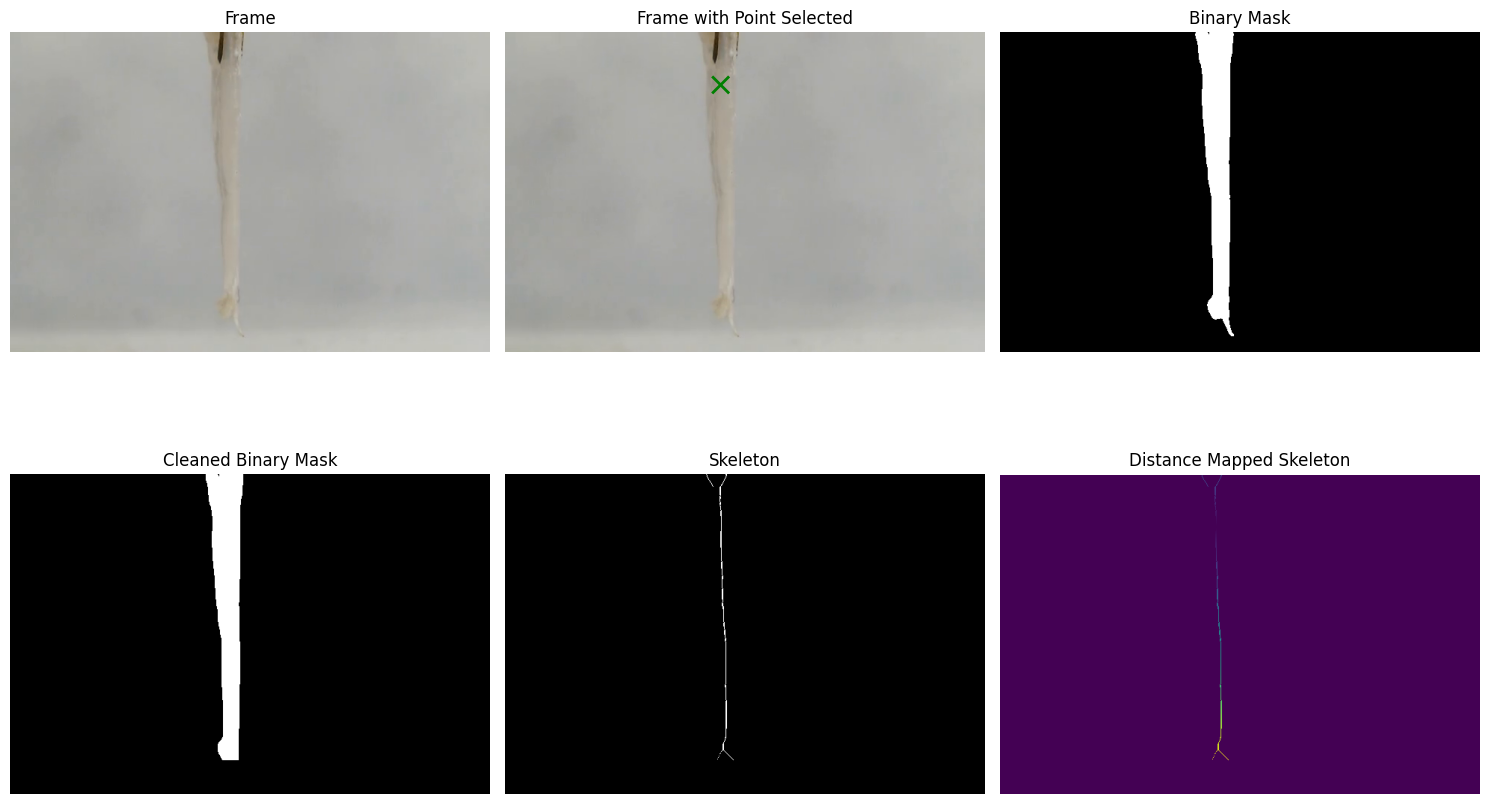

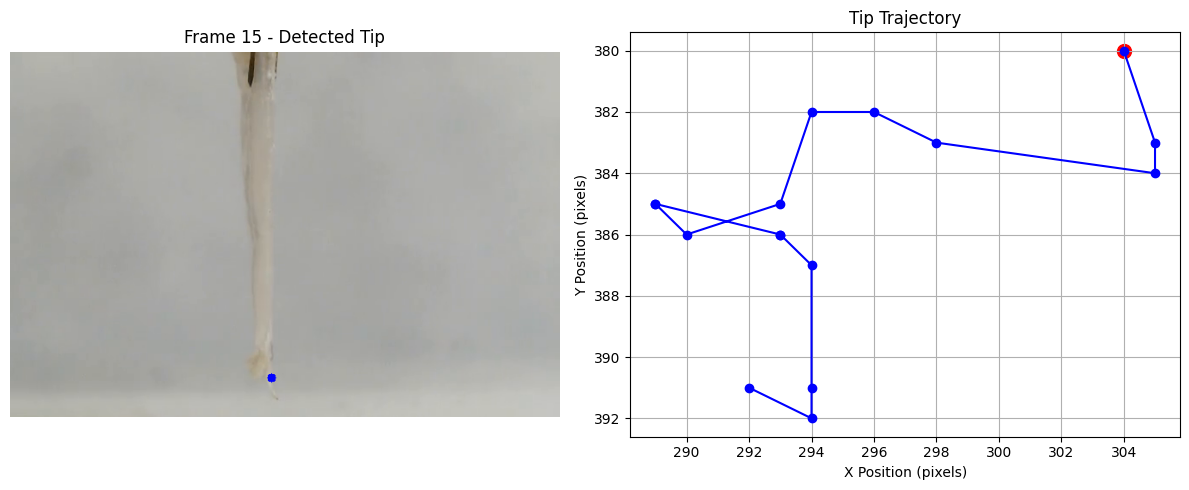


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_017.png: 1024x1024 1 0, 336.2ms
Speed: 4.9ms preprocess, 336.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
756 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_018.png: 1024x1024 1 0, 348.4ms
Speed: 3.0ms preprocess, 348.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
732 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_019.png: 1024x1024 1 0, 334.3ms
Speed: 3.2ms preprocess, 334.3ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
718 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_020.png: 1024x1024 1 0, 337.6ms
Speed: 3.1ms preprocess, 337.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)
698 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_021.png: 1024x1024 1 0

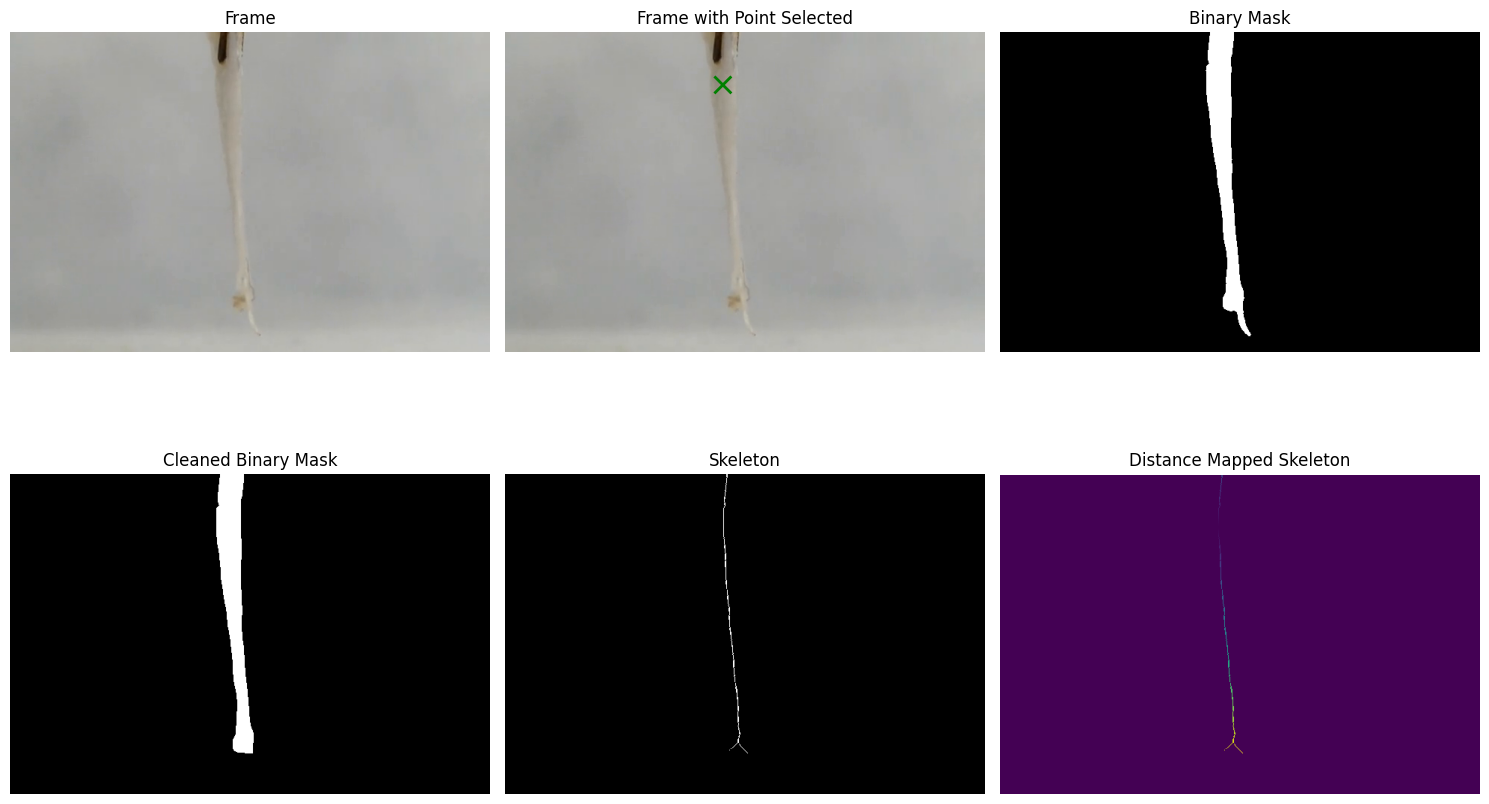

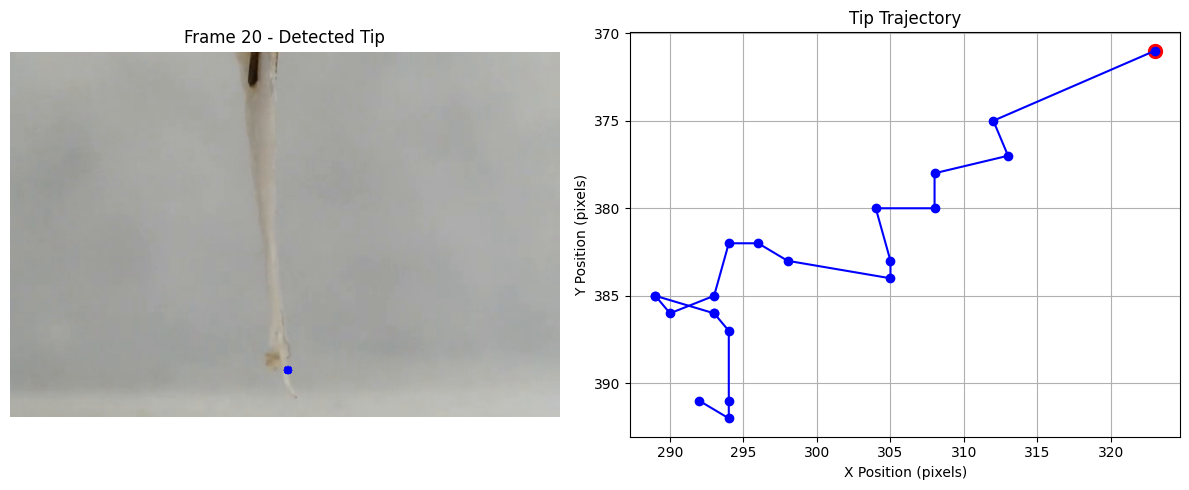


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_022.png: 1024x1024 1 0, 347.7ms
Speed: 4.8ms preprocess, 347.7ms inference, 2.4ms postprocess per image at shape (1, 3, 1024, 1024)
673 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_023.png: 1024x1024 1 0, 335.1ms
Speed: 3.4ms preprocess, 335.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
659 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_024.png: 1024x1024 1 0, 334.6ms
Speed: 3.1ms preprocess, 334.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
637 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_025.png: 1024x1024 1 0, 334.6ms
Speed: 3.1ms preprocess, 334.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
634 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_026.png: 1024x1024 1 0

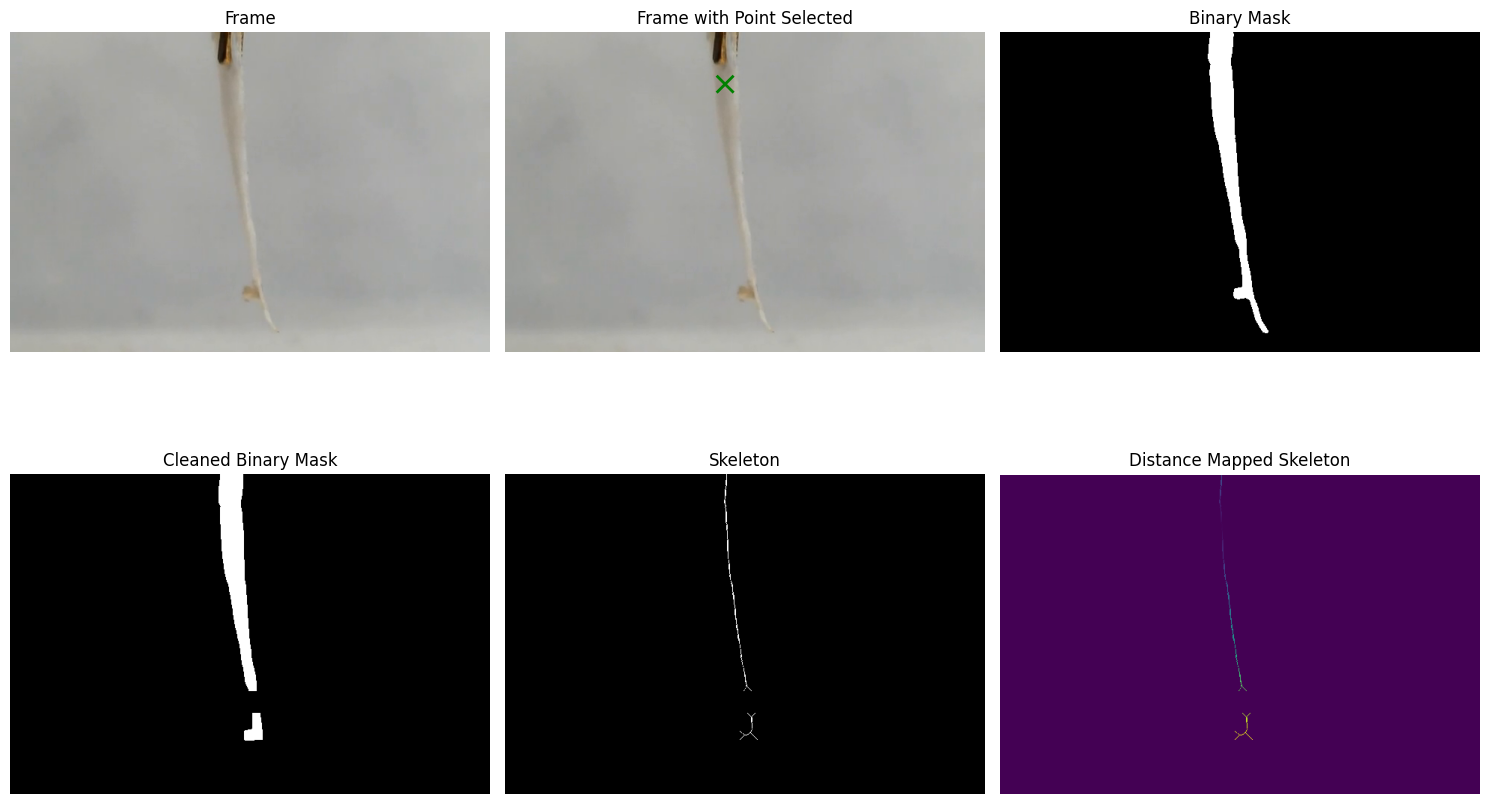

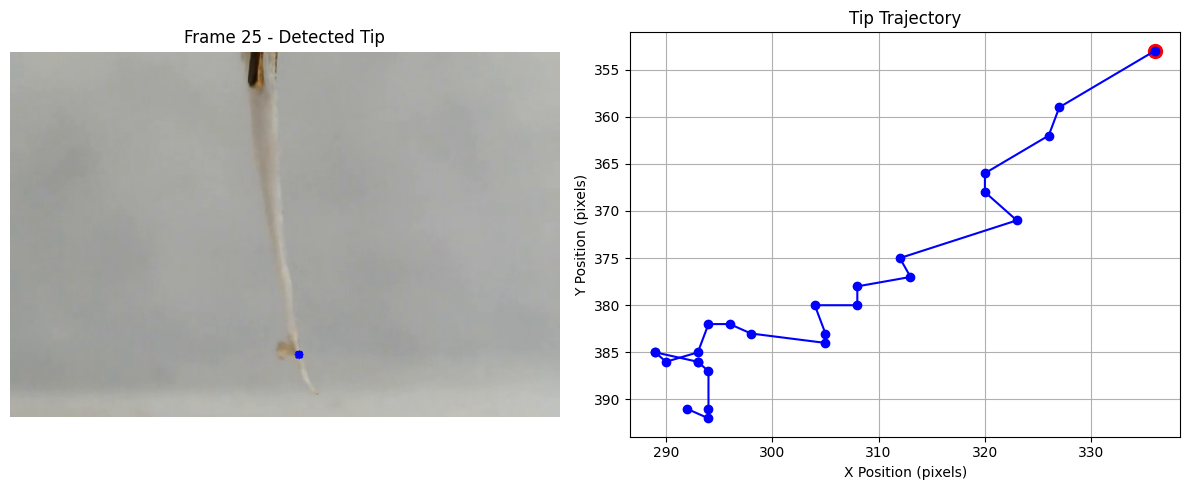


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_027.png: 1024x1024 1 0, 343.7ms
Speed: 4.8ms preprocess, 343.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
648 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_028.png: 1024x1024 1 0, 336.0ms
Speed: 3.1ms preprocess, 336.0ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
649 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_029.png: 1024x1024 1 0, 335.3ms
Speed: 3.2ms preprocess, 335.3ms inference, 0.6ms postprocess per image at shape (1, 3, 1024, 1024)
662 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_030.png: 1024x1024 1 0, 336.4ms
Speed: 3.1ms preprocess, 336.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
648 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_031.png: 1024x1024 1 0

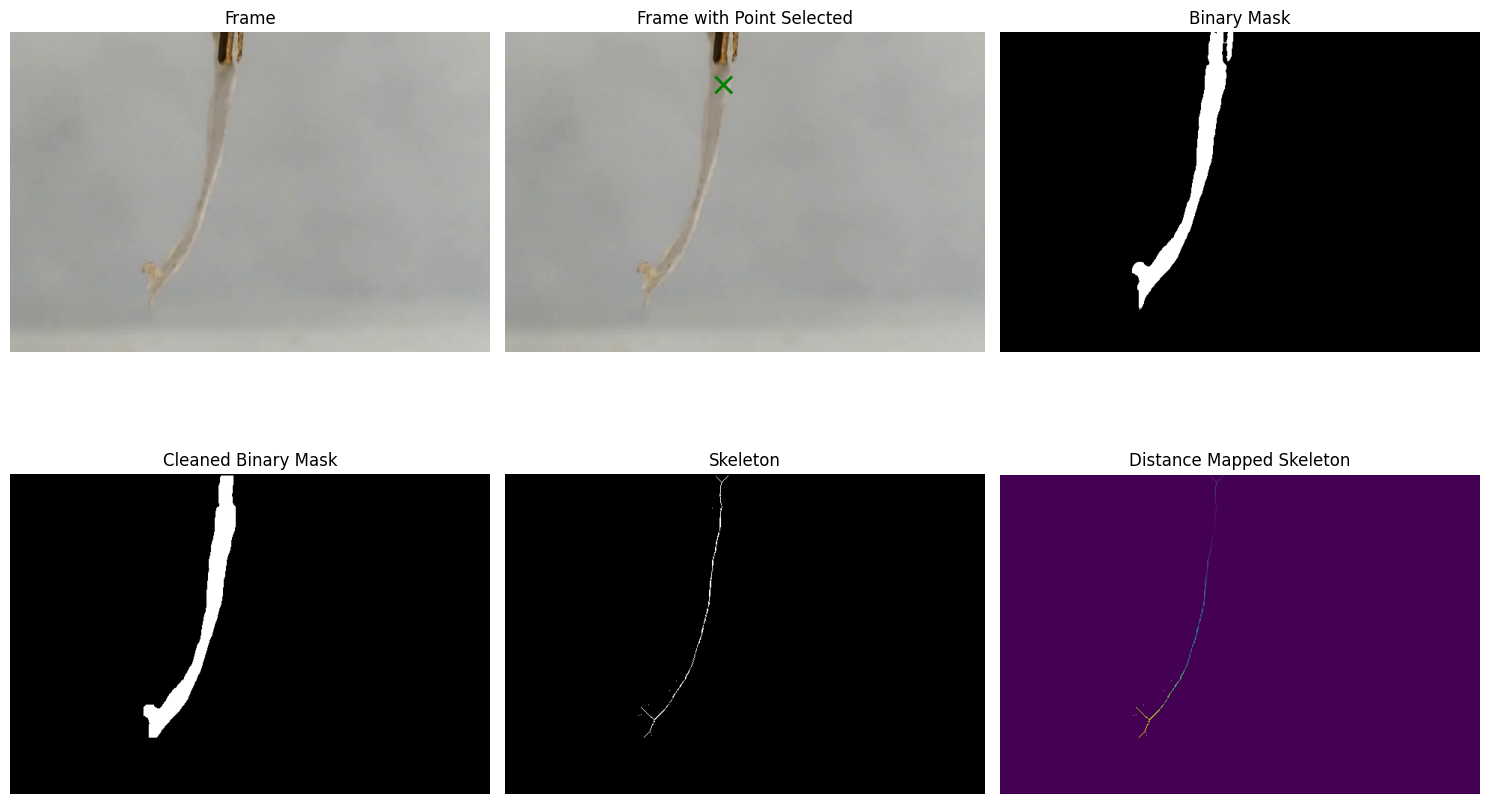

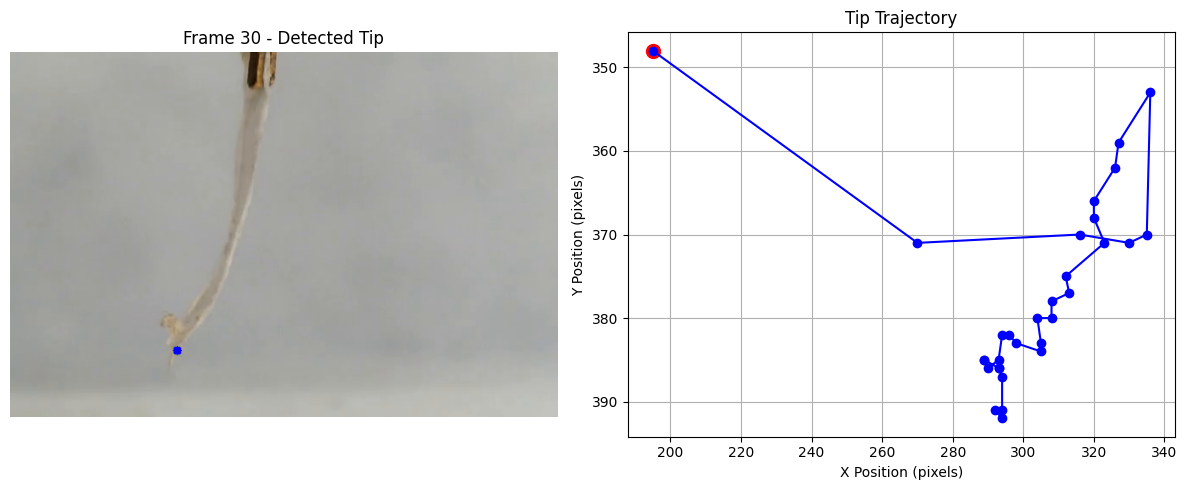


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_032.png: 1024x1024 1 0, 336.6ms
Speed: 4.9ms preprocess, 336.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
408 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_033.png: 1024x1024 1 0, 350.2ms
Speed: 3.1ms preprocess, 350.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
424 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_034.png: 1024x1024 1 0, 340.5ms
Speed: 3.1ms preprocess, 340.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
420 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_035.png: 1024x1024 1 0, 338.4ms
Speed: 3.1ms preprocess, 338.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
422 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_036.png: 1024x1024 1 0

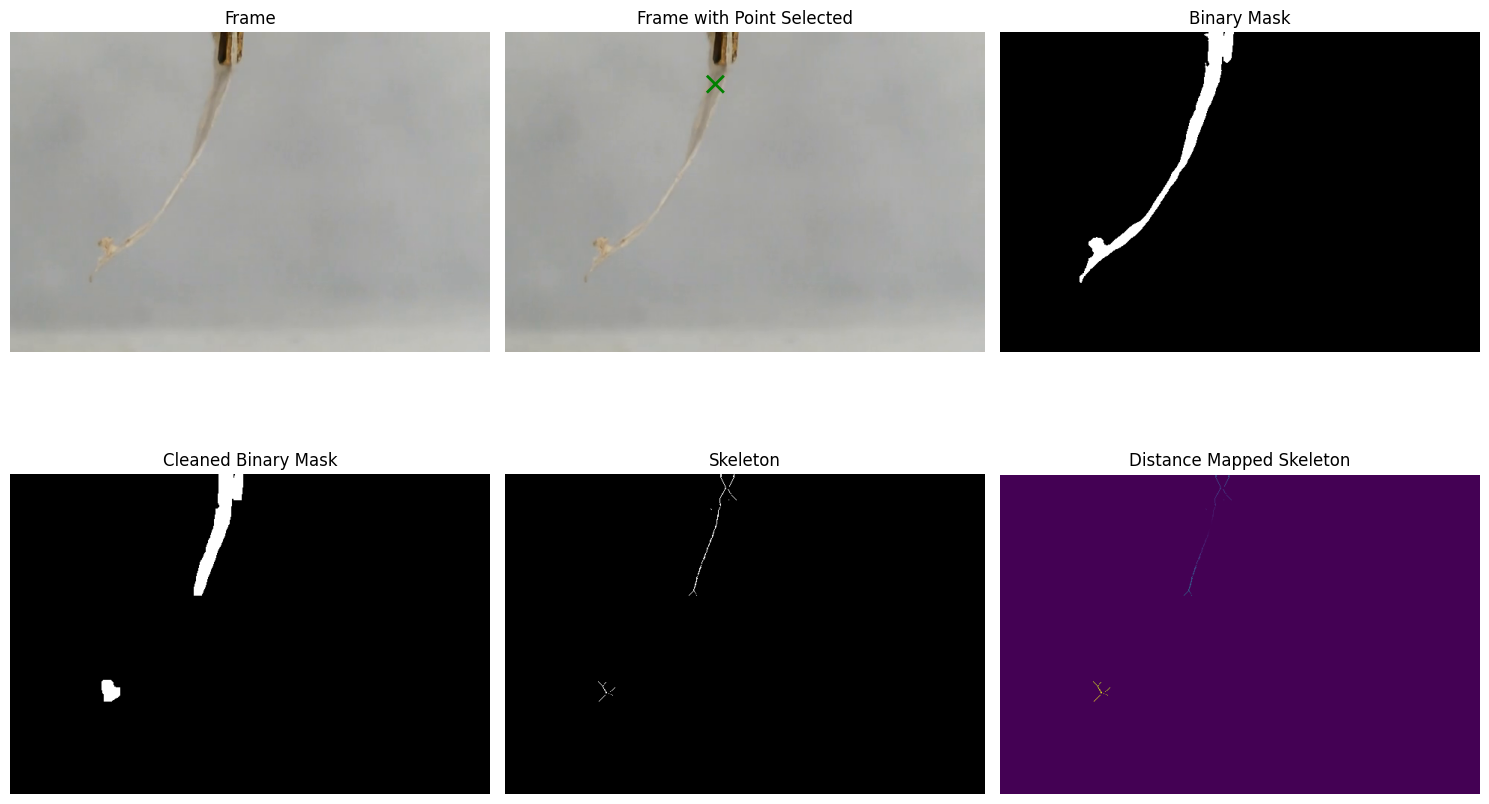

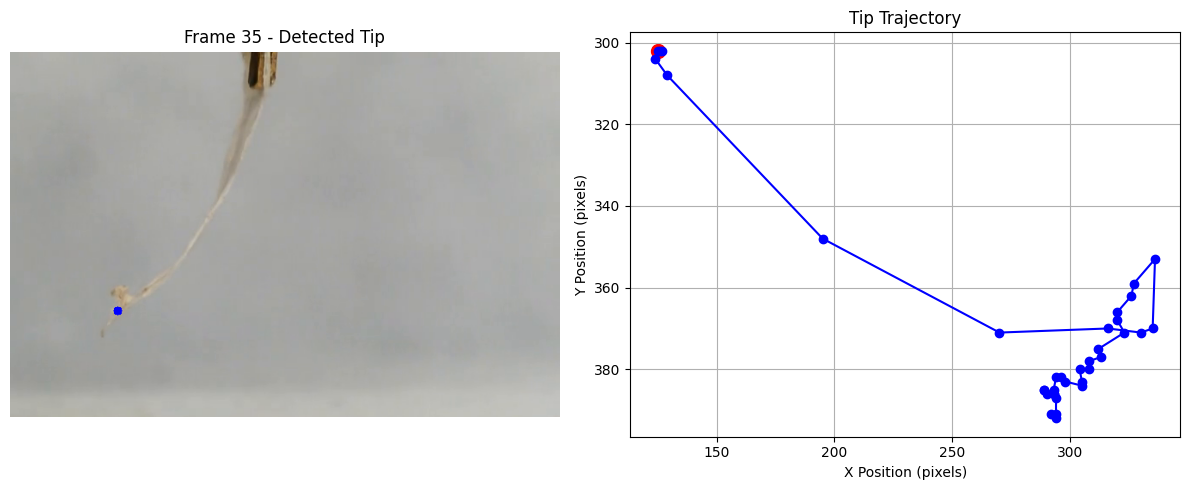


image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_037.png: 1024x1024 1 0, 333.2ms
Speed: 3.0ms preprocess, 333.2ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
417 0 640

image 1/1 /home/yitongt/Documents/Github/cellulose_origami/tracking_frames/frame_038.png: 1024x1024 1 0, 345.6ms
Speed: 3.2ms preprocess, 345.6ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
413 0 640


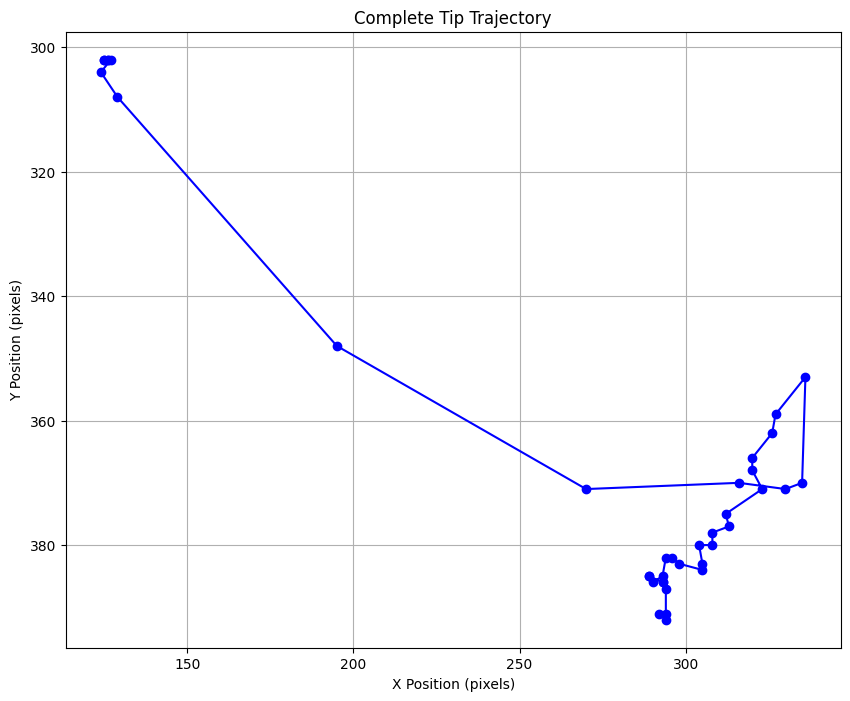

In [68]:
# Set paths
video_name = f"bimorph_idx5_100x" 
video_path = f"bimorph_videos/{video_name}.mov"
temp_folder = "tracking_frames/"
start_frame = 0
end_frame = None
frame_interval=0.6
point = (280, 100)

extract_frames(video_path, temp_folder, interval=frame_interval)

track_actuator_tip(
    frame_folder=temp_folder,
    start_frame=start_frame,
    end_frame=end_frame,
    output_file=f"tracked_trajectories/{video_name}_tracked.csv",
    json_output_file=f"tracked_trajectories/{video_name}_json.csv",
    anchor_point=point,
    edge_cushion =0,
    maximum_tip_travel_between_frames = 150,
    tip_margin = 20,
    debug=False,
    wandering_point_bottpm=80,
    opening_kernel=(1,1)
)

for filename in os.listdir(temp_folder):
    file_path = os.path.join(temp_folder, filename)
    if os.path.isdir(file_path):
        shutil.rmtree(file_path)
    else:
        os.remove(file_path)